<h1 align="center" style="color:#6699ff"> DataCamp IEEE Fraud Detection </h1>

<img src="https://github.com/DataCampM2DSSAF/suivi-du-data-camp-equipe-tchouacheu_toure_niang_chokki/blob/master/img/credit-card-fraud-detection.png?raw=true" width="800" align="right">

#  <a style="color:#6699ff"> Team </a>
- <a style="color:#6699ff">Mohamed NIANG </a>
- <a style="color:#6699ff">Fernanda TCHOUACHEU </a>
- <a style="color:#6699ff">Sokhna Penda TOURE </a>
- <a style="color:#6699ff">Hypolite CHOKKI </a>

# <a style="color:#6699ff">  Table of Contents</a> 

<a style="color:#6699ff"> I. Introduction</a>

<a style="color:#6699ff"> II. Descriptive Statistics & Visualization</a>

<a style="color:#6699ff"> III. Preprocessing</a>

<a style="color:#6699ff"> IV. Machine Learning Models</a>

# <a style="color:#6699ff"> I. Introduction</a>

**Pourquoi la détection de fraude ?**
> La fraude est un commerce d'un milliard de dollars et elle augmente chaque année. L'enquête mondiale de PwC sur la criminalité économique de 2018 a révélé que la moitié (49 %) des 7 200 entreprises interrogées avaient été victimes d'une fraude quelconque. C'est une augmentation par rapport à l'étude PwC de 2016, dans laquelle un peu plus d'un tiers des organisations interrogées (36 %) avaient été victimes de la criminalité économique.


Cette compétition est un problème de **classification binaire** - c'est-à-dire que notre variable cible est un attribut binaire (l'utilisateur qui fait le clic est-il frauduleux ou non ?) et notre objectif est de classer les utilisateurs en "frauduleux" ou "non frauduleux" le mieux possible.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file 

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
#from xgboost import XGBClassifier
#import xgboost as xgb
#import lightgbm as lgb
#import catboost
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score
import matplotlib.gridspec as gridspec
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import gc
gc.enable()

import os
#os.chdir('/kaggle/input/ieeecis-fraud-detection') # Set working directory
#print(os.listdir('/kaggle/input/ieeecis-fraud-detection'))

# <a style="color:#6699ff"> II. Descriptive Statistics and Visualization</a>

Dans cette compétition, nous voulons prédire la probabilité qu'une transaction en ligne soit frauduleuse, comme le montre la cible binaire "isFraud".

Les données sont divisées en deux fichiers **identity** et **transaction**, qui sont reliés par "TransactionID". 

> Note : Toutes les transactions n'ont pas d'informations d'identité correspondantes.

**Variables catégorielles - Transaction**

- ProductCD
- emaildomain
- card1 - card6
- addr1, addr2
- P_emaildomain
- R_emaildomain
- M1 - M9

**Variables catégorielles - Identité**

- DeviceType
- DeviceInfo
- id_12 - id_38

**La variable TransactionDT est le temps d'une date-heure de référence donnée (en seconde).**

**Fichiers**

- train_{transaction, identité}.csv - l'ensemble d'apprentissage
- test_{transaction, identité}.csv - l'ensemble de test (**nous devons prédire la valeur isFraud pour ces observations**)
- sample_submission.csv - un exemple de fichier de soumission dans le format correct

> Questions

Nous allons commencer à explorer les données en se basant sur les caractéristiques catégorielles et les montants des transactions. L'objectif est de répondre à des questions comme :

1. Quel type de données avons-nous ?
2. Combien de cols, de lignes, de valeurs manquantes avons-nous ?
3. Quelle est la distribution cible ?
4. Quelle est la distribution des valeurs des transactions de fraude et des transactions sans fraude ?
5. Avons nous des produits frauduleux prédominants ?
6. Quelles sont les caractéristiques ou la cible qui présentent des schémas intéressants ?

Et beaucoup d'autres questions qui vont soulever l'exploration.

**Load data**

In [27]:
%%time
train_transaction = pd.read_csv('train_transaction.csv', index_col='TransactionID')
test_transaction = pd.read_csv('test_transaction.csv', index_col='TransactionID')
train_identity = pd.read_csv('train_identity.csv', index_col='TransactionID')
test_identity = pd.read_csv('test_identity.csv', index_col='TransactionID')
print ("Data is loaded!")

Data is loaded!
Wall time: 4min 18s


In [28]:
print('train_transaction shape is {}'.format(train_transaction.shape))
print('test_transaction shape is {}'.format(test_transaction.shape))
print('train_identity shape is {}'.format(train_identity.shape))
print('test_identity shape is {}'.format(test_identity.shape))

train_transaction shape is (590540, 393)
test_transaction shape is (506691, 392)
train_identity shape is (144233, 40)
test_identity shape is (141907, 40)


In [6]:
train_transaction.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
train_identity.head()

,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


**Missing Data Problem**

On remarque qu'il y a beaucoup de colonnes **NaN** : 

- ``` V300 ... V339``` 
- ``` id_01 ... id_34``` 

## 1er problème : NaN

**train_transaction**

In [29]:
missing_values_count = train_transaction.isnull().sum()
print (missing_values_count[0:10])
total_cells = np.product(train_transaction.shape)
total_missing = missing_values_count.sum()
print ("% of missing data = ",(total_missing/total_cells) * 100)

isFraud              0
TransactionDT        0
TransactionAmt       0
ProductCD            0
card1                0
card2             8933
card3             1565
card4             1577
card5             4259
card6             1571
dtype: int64
% of missing data =  41.17794374769424


**train_identity**

In [30]:
missing_values_count = train_identity.isnull().sum()
print (missing_values_count[0:10])
total_cells = np.product(train_identity.shape)
total_missing = missing_values_count.sum()
print ("% of missing data = ",(total_missing/total_cells) * 100)

id_01         0
id_02      3361
id_03     77909
id_04     77909
id_05      7368
id_06      7368
id_07    139078
id_08    139078
id_09     69307
id_10     69307
dtype: int64
% of missing data =  36.47062392101669


In [31]:
del missing_values_count, total_cells, total_missing
gc.collect()

113

**Imbalanced Problem**

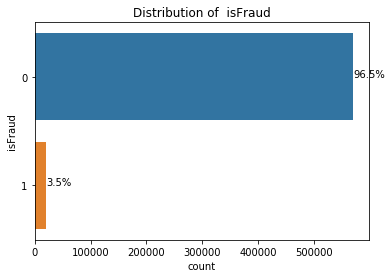

In [32]:
ax = sns.countplot(y="isFraud", data=train_transaction)
plt.title('Distribution of  isFraud')

total = len(train_transaction['isFraud'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

plt.show()

## 2ème problème : Imbalanced class

Nous remarquons que notre jeu de données ("isFraud") est déséquilibrée. La plupart des transactions sont non frauduleuses. Si nous utilisons ce cadre de données comme base pour nos modèles prédictifs et nos analyses, nous pourrions obtenir beaucoup d'erreurs et nos algorithmes seront probablement surdimensionnés puisqu'ils "supposeront" que la plupart des transactions ne sont pas des fraudes. Mais nous ne voulons pas que notre modèle suppose, nous voulons que notre modèle détecte des modèles qui donnent des signes de fraude !

**Déséquilibrée** signifie que le nombre de points de données disponibles pour les différentes classes est différent.

Dans cette partie, nous essayerons de voir, d'une part, ce que réprésente réellement certaines variables,
et d'autre part, s'il y a des liens entre les variables et la variable cible.

In [34]:
train_transaction['TransactionDT'].head()

TransactionID
2987000    86400
2987001    86401
2987002    86469
2987003    86499
2987004    86506
Name: TransactionDT, dtype: int64

In [11]:
train_transaction['TransactionDT'].shape[0] , train_transaction['TransactionDT'].nunique()

(590540, 573349)

In [12]:
train_transaction['TransactionDT'].value_counts().head(10)

9474817     8
11576951    5
7236588     5
4397066     5
8468062     4
8020359     4
7337054     4
5334992     4
1971839     4
1962054     4
Name: TransactionDT, dtype: int64

## Distribution Plots

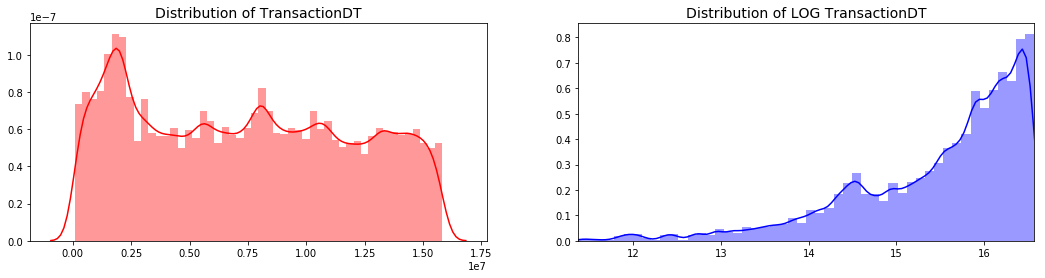

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

time_val = train_transaction['TransactionDT'].values

sns.distplot(time_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of TransactionDT', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

sns.distplot(np.log(time_val), ax=ax[1], color='b')
ax[1].set_title('Distribution of LOG TransactionDT', fontsize=14)
ax[1].set_xlim([min(np.log(time_val)), max(np.log(time_val))])

plt.show()

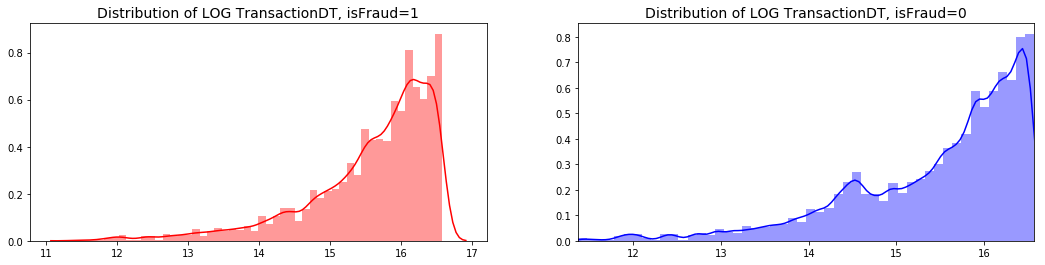

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

time_val = train_transaction.loc[train_transaction['isFraud'] == 1]['TransactionDT'].values

sns.distplot(np.log(time_val), ax=ax[0], color='r')
ax[0].set_title('Distribution of LOG TransactionDT, isFraud=1', fontsize=14)
ax[1].set_xlim([min(np.log(time_val)), max(np.log(time_val))])

time_val = train_transaction.loc[train_transaction['isFraud'] == 0]['TransactionDT'].values

sns.distplot(np.log(time_val), ax=ax[1], color='b')
ax[1].set_title('Distribution of LOG TransactionDT, isFraud=0', fontsize=14)
ax[1].set_xlim([min(np.log(time_val)), max(np.log(time_val))])


plt.show()

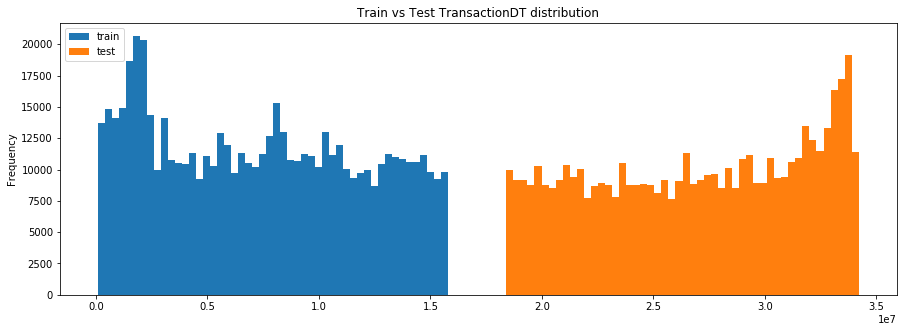

In [15]:
train_transaction['TransactionDT'].plot(kind='hist',
                                        figsize=(15, 5),
                                        label='train',
                                        bins=50,
                                        title='Train vs Test TransactionDT distribution')
test_transaction['TransactionDT'].plot(kind='hist',
                                       label='test',
                                       bins=50)
plt.legend()
plt.show()

In [36]:
del fig, ax, time_val
gc.collect()

9809

In [37]:
train_transaction.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**isFraud vs time**

In [3]:
i = 'isFraud'
#cor = np.corrcoef(train_transaction['TransactionDT'], train_transaction[i])[0,1]
#train_transaction.loc[train_transaction['isFraud'] == 0].set_index('TransactionDT')[i].plot(style='.', title=i+" corr= "+str(round(cor,3)), figsize=(15, 3), label="isFraud=0")
#train_transaction.loc[train_transaction['isFraud'] == 1].set_index('TransactionDT')[i].plot(style='.', title=i+" corr= "+str(round(cor,3)), figsize=(15, 3), label="isFraud=1")
#plt.legend()
#plt.show()

**C features: C1, C2 ... C14**

In [15]:
c_features = list(train_transaction.columns[16:30])

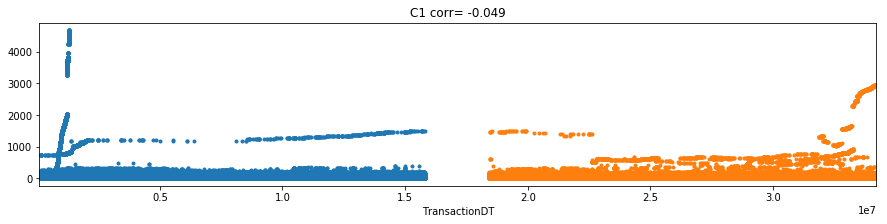

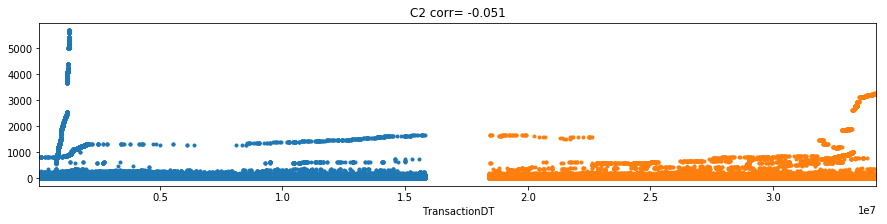

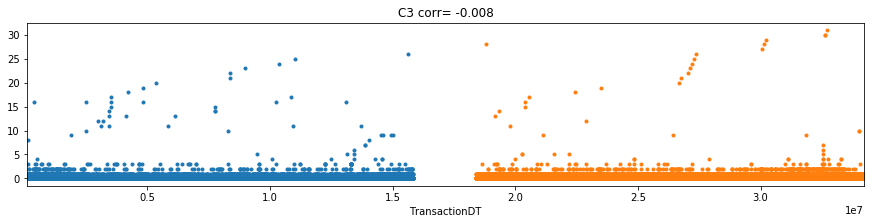

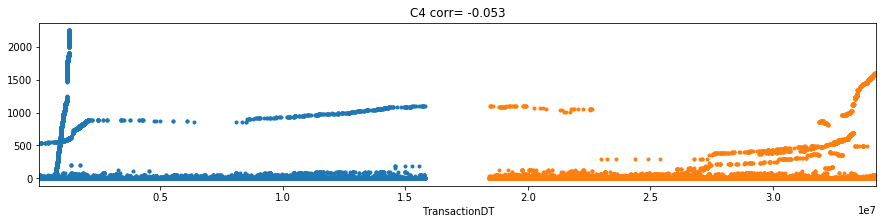

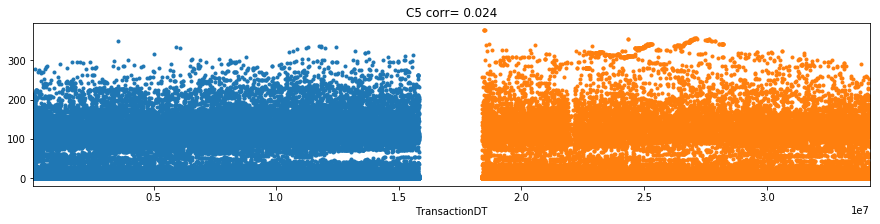

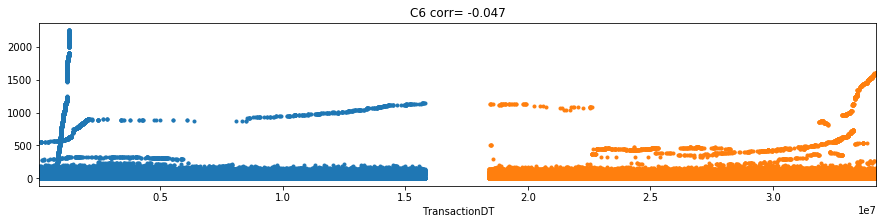

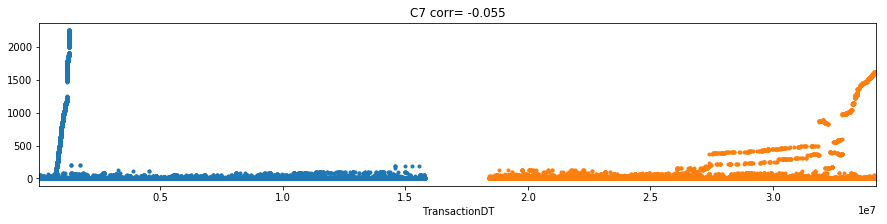

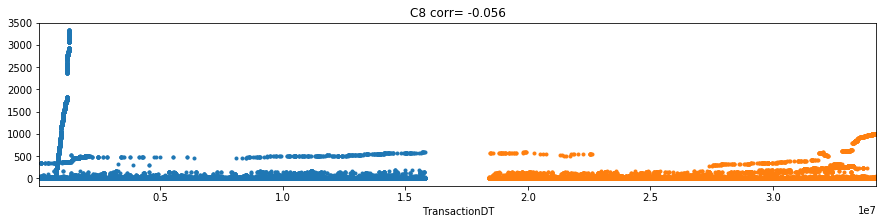

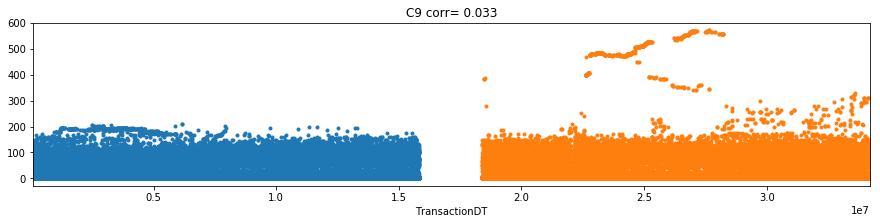

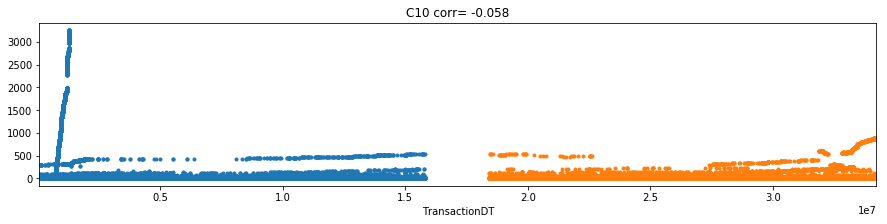

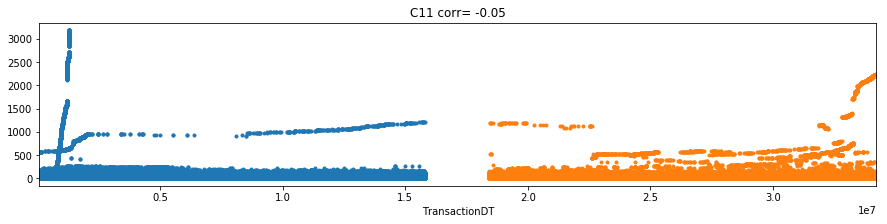

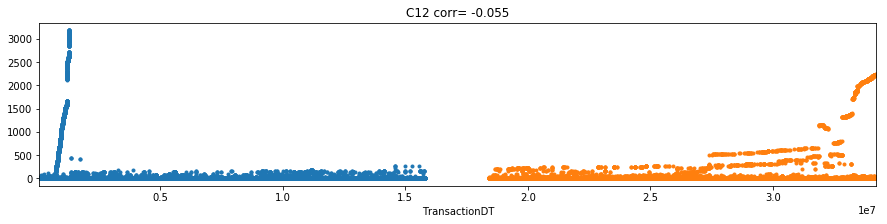

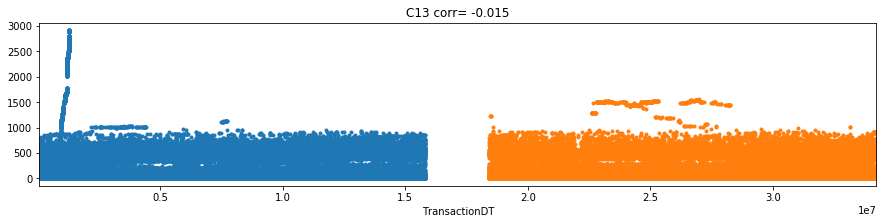

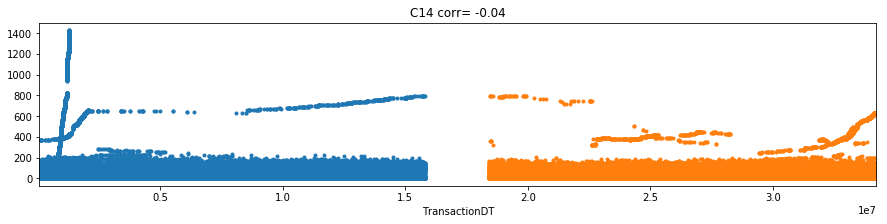

In [19]:
c_features = list(train_transaction.columns[16:30])
for i in c_features:
    cor = np.corrcoef(train_transaction['TransactionDT'], train_transaction[i])[0,1]
    train_transaction.set_index('TransactionDT')[i].plot(style='.', title=i+" corr= "+str(round(cor,3)), figsize=(15, 3))
    test_transaction.set_index('TransactionDT')[i].plot(style='.', title=i+" corr= "+str(round(cor,3)), figsize=(15, 3))
    plt.show()

In [20]:
del cor, c_features
gc.collect()

35177

**D features: D1 ... D15**

In [41]:
d_features = list(train_transaction.columns[30:45])

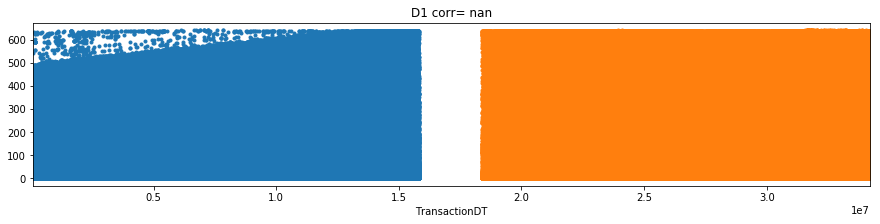

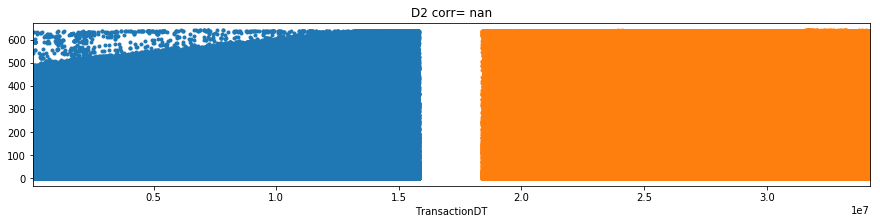

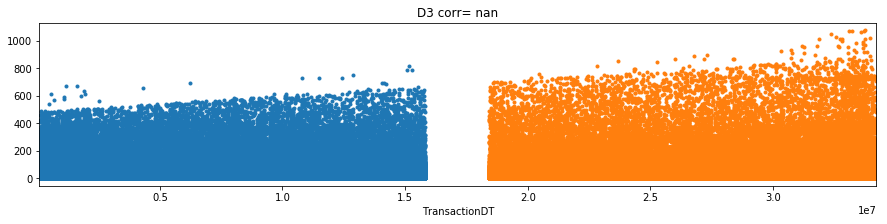

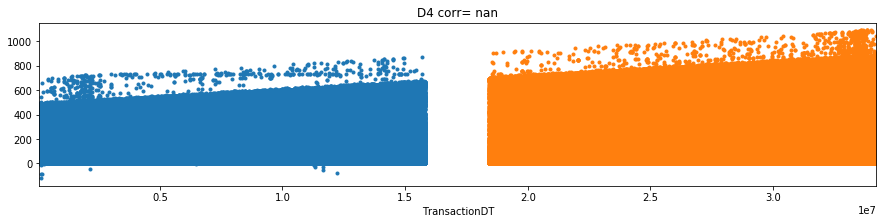

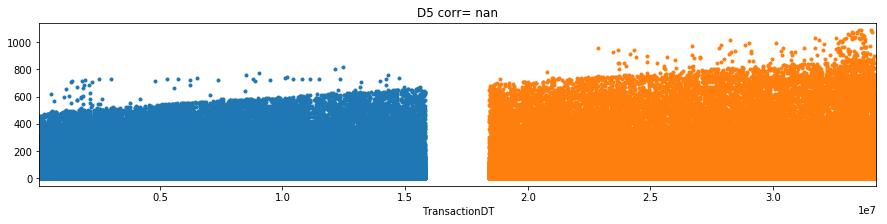

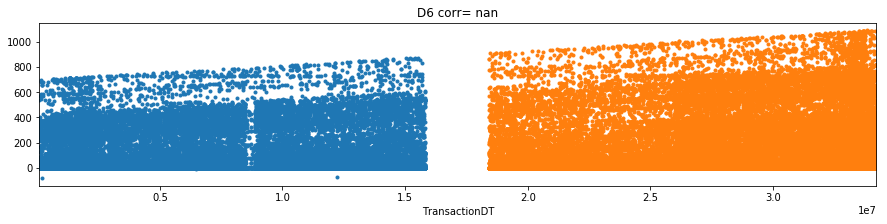

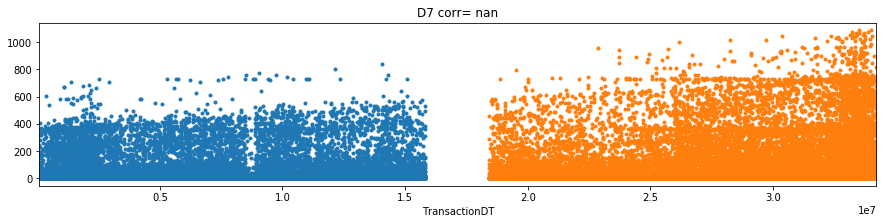

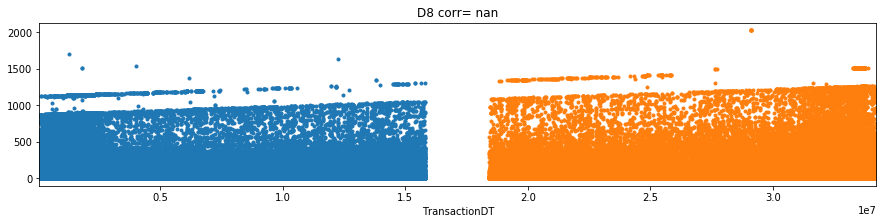

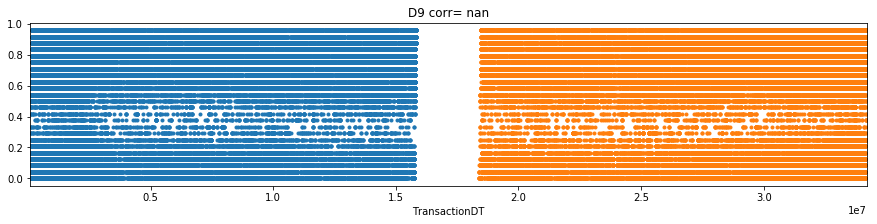

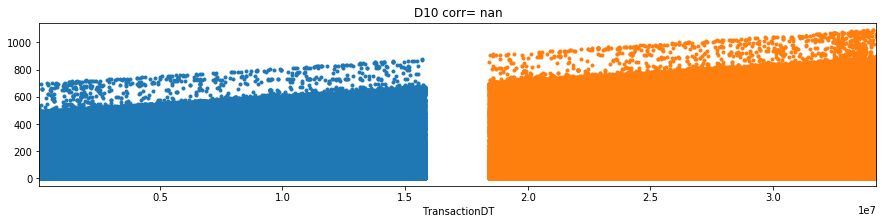

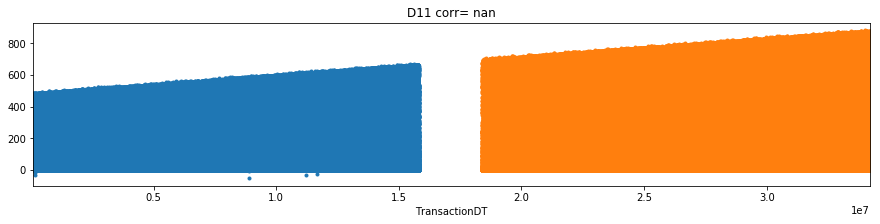

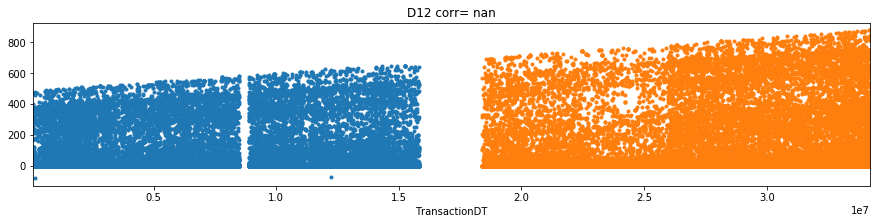

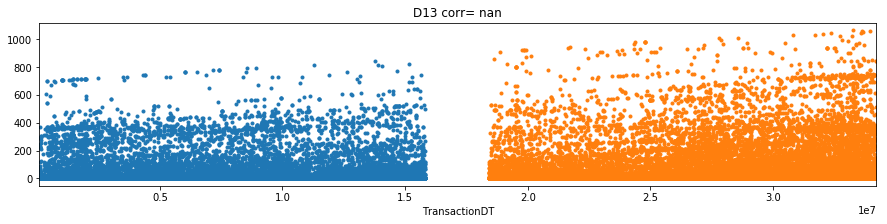

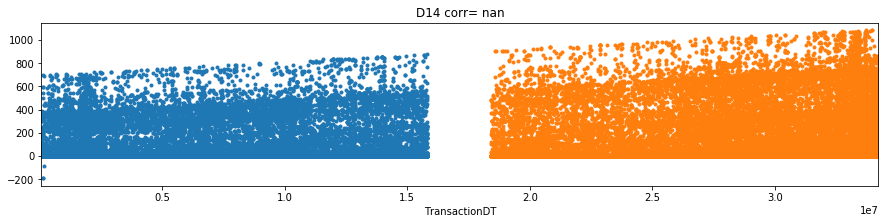

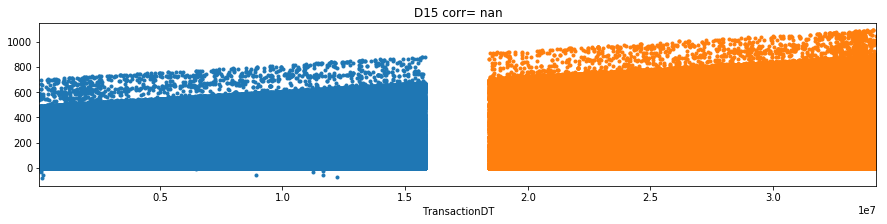

In [21]:
d_features = list(train_transaction.columns[30:45])

for i in d_features:
    cor = np.corrcoef(train_transaction['TransactionDT'], train_transaction[i])[0,1]
    train_transaction.set_index('TransactionDT')[i].plot(style='.', title=i+" corr= "+str(round(cor,3)), figsize=(15, 3))
    test_transaction.set_index('TransactionDT')[i].plot(style='.', title=i+" corr= "+str(round(cor,3)), figsize=(15, 3))
    plt.show()

Le problème ici est que les caractéristiques D sont principalement des NaNs.

In [42]:
train_transaction[d_features].head()

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
TransactionID,,,,,,,,,,,,,,,
2987000,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0
2987001,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0
2987002,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0
2987003,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,111.0
2987004,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
# Click output to see the number of missing values in each column
missing_values_count = train_transaction[d_features].isnull().sum()
missing_values_count

D1       1269
D2     280797
D3     262878
D4     168922
D5     309841
D6     517353
D7     551623
D8     515614
D9     515614
D10     76022
D11    279287
D12    525823
D13    528588
D14    528353
D15     89113
dtype: int64

In [44]:
# how many total missing values do we have?
total_cells = np.product(train_transaction[d_features].shape)
total_missing = missing_values_count.sum()
# percent of data that is missing
(total_missing/total_cells) * 100

58.15126268612908

Si nous considérons les caractéristiques D, 58.15% sont des valeurs manquantes.

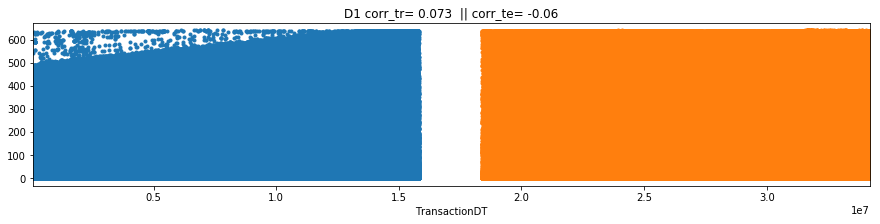

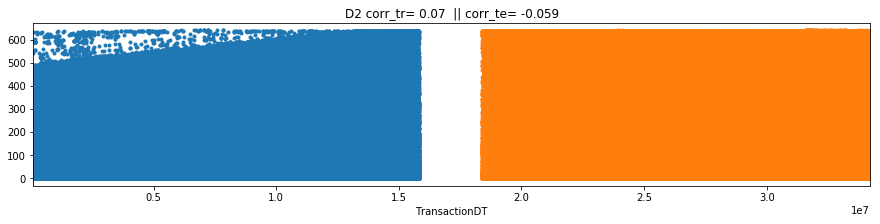

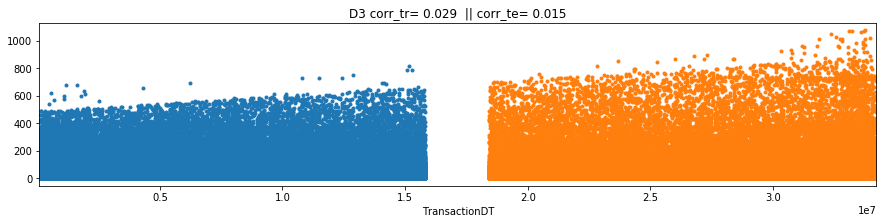

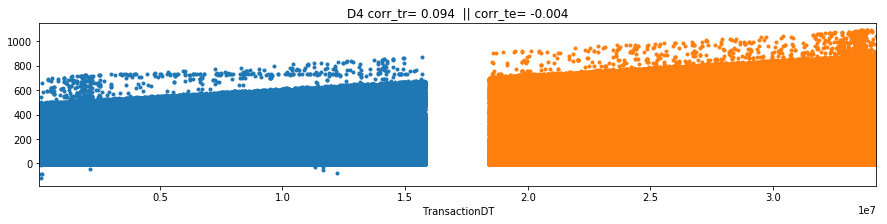

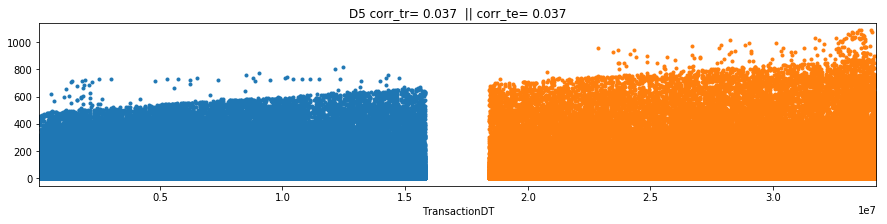

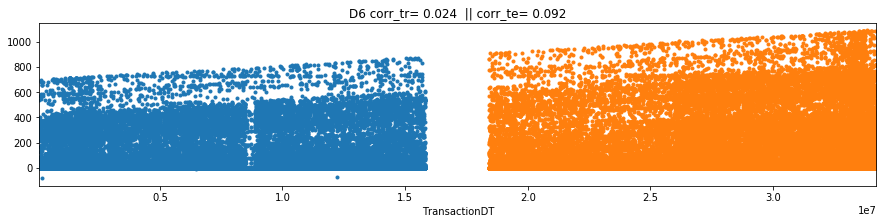

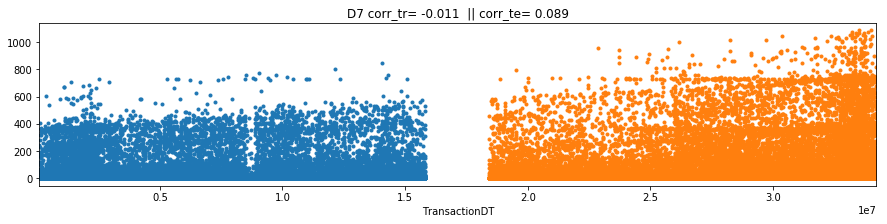

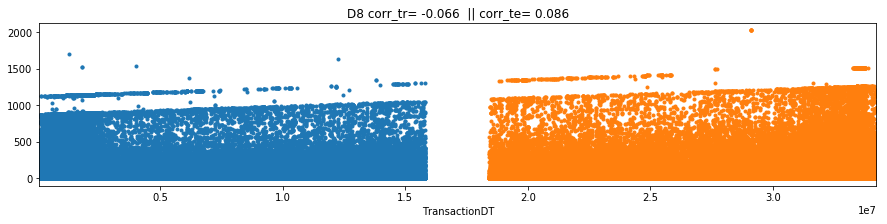

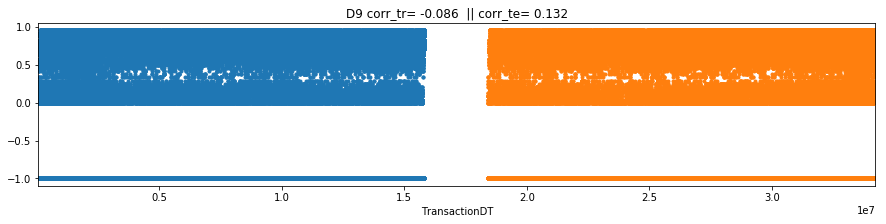

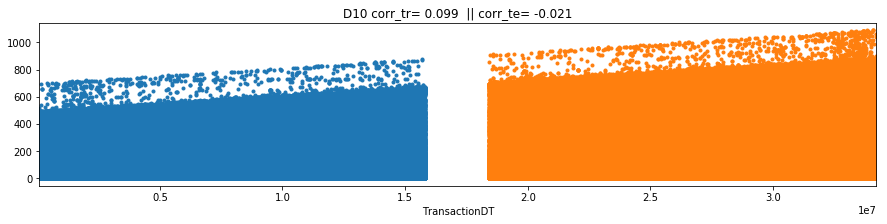

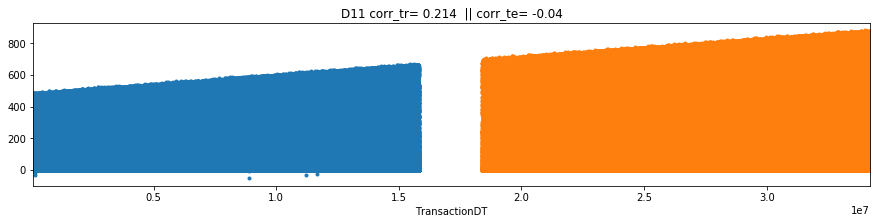

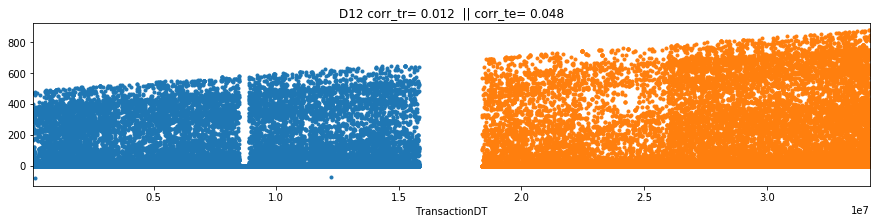

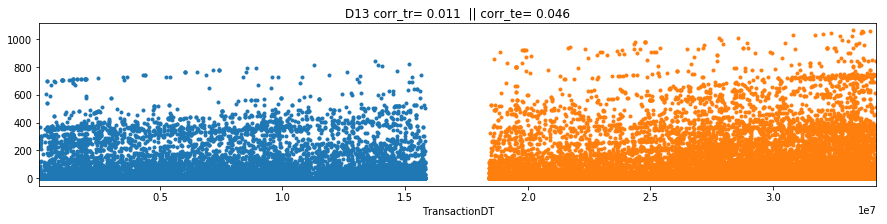

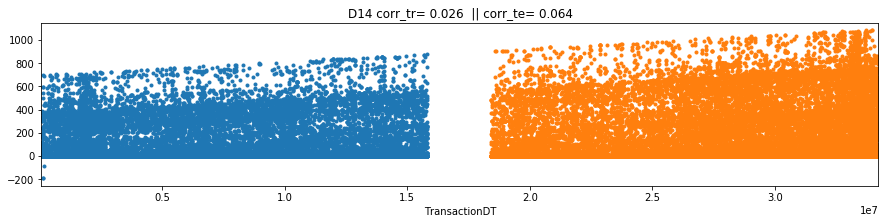

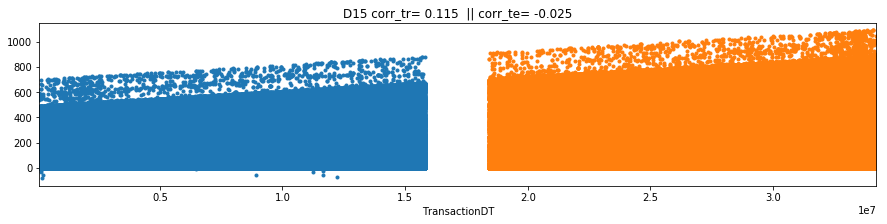

In [25]:
for i in d_features:
    cor_tr = np.corrcoef(train_transaction['TransactionDT'], train_transaction[i].fillna(-1))[0,1]
    cor_te = np.corrcoef(test_transaction['TransactionDT'], test_transaction[i].fillna(-1))[0,1]
    train_transaction.set_index('TransactionDT')[i].fillna(-1).plot(style='.', title=i+" corr_tr= "+str(round(cor_tr,3))+" || corr_te= "+str(round(cor_te,3)), figsize=(15, 3))
    test_transaction.set_index('TransactionDT')[i].fillna(-1).plot(style='.', title=i+" corr_tr= "+str(round(cor_tr,3))+"  || corr_te= "+str(round(cor_te,3)), figsize=(15, 3))
    plt.show()

In [45]:
del d_features, cor, missing_values_count, total_cells, total_missing
gc.collect()

108

**M features: M1 .. M9**

In [46]:
m_features = list(train_transaction.columns[45:54])
train_transaction[m_features].head()

,M1,M2,M3,M4,M5,M6,M7,M8,M9
TransactionID,,,,,,,,,
2987000,T,T,T,M2,F,T,NaN,NaN,NaN
2987001,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN
2987002,T,T,T,M0,F,F,F,F,F
2987003,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN
2987004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**V150**

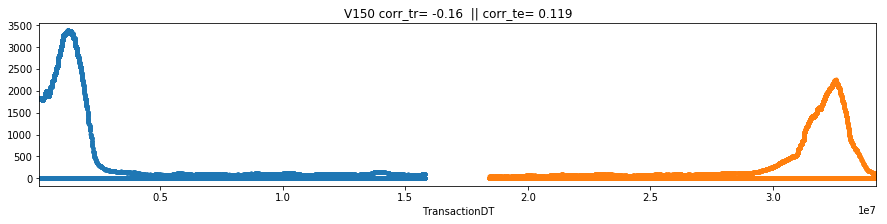

In [28]:
i = "V150"
cor_tr = np.corrcoef(train_transaction['TransactionDT'], train_transaction[i].fillna(-1))[0,1]
cor_te = np.corrcoef(test_transaction['TransactionDT'], test_transaction[i].fillna(-1))[0,1]
train_transaction.set_index('TransactionDT')[i].fillna(-1).plot(style='.', title=i+" corr_tr= "+str(round(cor_tr,3))+" || corr_te= "+str(round(cor_te,3)), figsize=(15, 3))
test_transaction.set_index('TransactionDT')[i].fillna(-1).plot(style='.', title=i+" corr_tr= "+str(round(cor_tr,3))+"  || corr_te= "+str(round(cor_te,3)), figsize=(15, 3))
plt.show()

In [29]:
del cor_tr, cor_te
gc.collect()

2438

Vérifions toute la liste des V qui sont nulles.

In [47]:
train_transaction.loc[:,train_transaction.columns[train_transaction.columns.str.startswith('V')]].isnull().sum()

V1      279287
V2      279287
V3      279287
V4      279287
V5      279287
V6      279287
V7      279287
V8      279287
V9      279287
V10     279287
V11     279287
V12      76073
V13      76073
V14      76073
V15      76073
V16      76073
V17      76073
V18      76073
V19      76073
V20      76073
V21      76073
V22      76073
V23      76073
V24      76073
V25      76073
V26      76073
V27      76073
V28      76073
V29      76073
V30      76073
         ...  
V310        12
V311        12
V312        12
V313      1269
V314      1269
V315      1269
V316        12
V317        12
V318        12
V319        12
V320        12
V321        12
V322    508189
V323    508189
V324    508189
V325    508189
V326    508189
V327    508189
V328    508189
V329    508189
V330    508189
V331    508189
V332    508189
V333    508189
V334    508189
V335    508189
V336    508189
V337    508189
V338    508189
V339    508189
Length: 339, dtype: int64

**TransactionAmt**

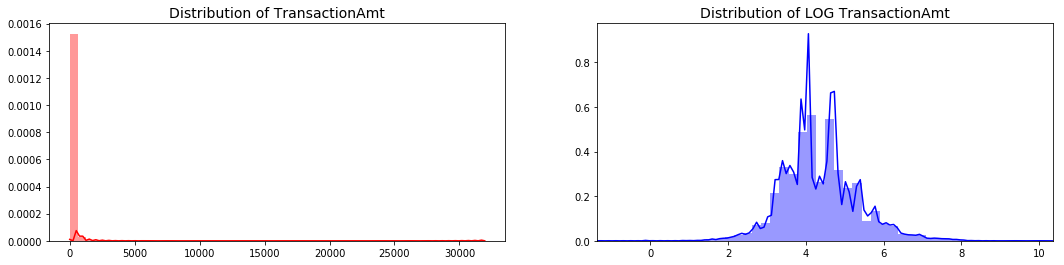

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

time_val = train_transaction['TransactionAmt'].values

sns.distplot(time_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of TransactionAmt', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

sns.distplot(np.log(time_val), ax=ax[1], color='b')
ax[1].set_title('Distribution of LOG TransactionAmt', fontsize=14)
ax[1].set_xlim([min(np.log(time_val)), max(np.log(time_val))])

plt.show()

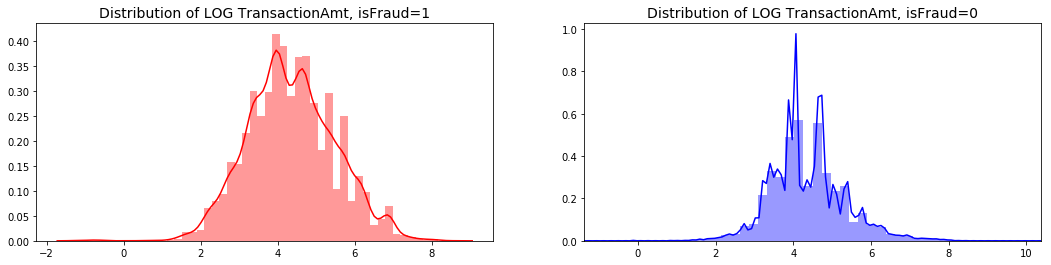

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

time_val = train_transaction.loc[train_transaction['isFraud'] == 1]['TransactionAmt'].values

sns.distplot(np.log(time_val), ax=ax[0], color='r')
ax[0].set_title('Distribution of LOG TransactionAmt, isFraud=1', fontsize=14)
ax[1].set_xlim([min(np.log(time_val)), max(np.log(time_val))])

time_val = train_transaction.loc[train_transaction['isFraud'] == 0]['TransactionAmt'].values

sns.distplot(np.log(time_val), ax=ax[1], color='b')
ax[1].set_title('Distribution of LOG TransactionAmt, isFraud=0', fontsize=14)
ax[1].set_xlim([min(np.log(time_val)), max(np.log(time_val))])


plt.show()

In [33]:
del fig, ax, time_val
gc.collect()

19515

## Count Plots

**D Features**

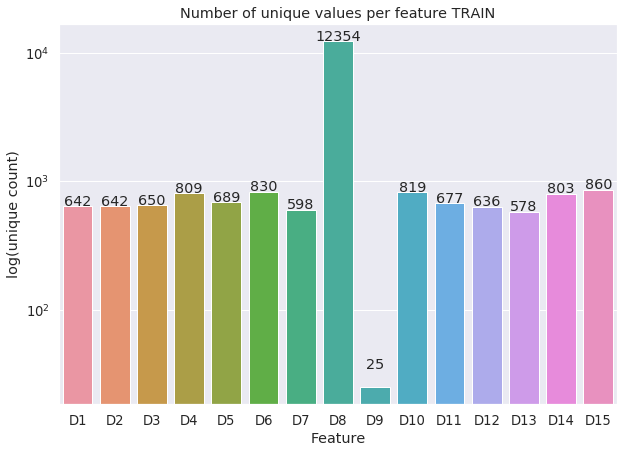

In [34]:
plt.figure(figsize=(10, 7))
d_features = list(train_transaction.columns[30:45])
uniques = [len(train_transaction[col].unique()) for col in d_features]
sns.set(font_scale=1.2)
ax = sns.barplot(d_features, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature TRAIN')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 

In [35]:
del d_features, uniques
gc.collect()

1784

**C features**

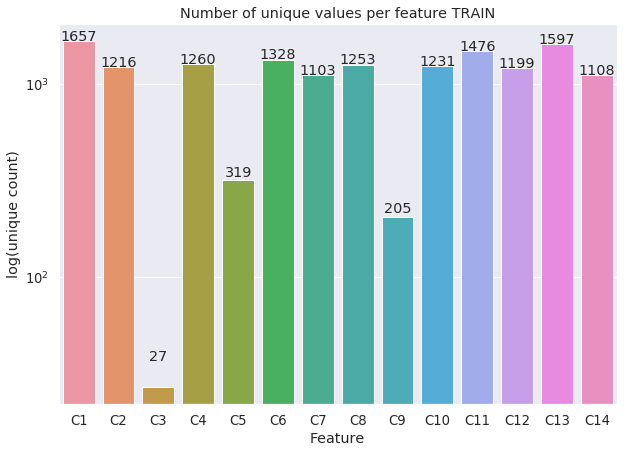

In [36]:
plt.figure(figsize=(10, 7))
c_features = list(train_transaction.columns[16:30])
uniques = [len(train_transaction[col].unique()) for col in c_features]
sns.set(font_scale=1.2)
ax = sns.barplot(c_features, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature TRAIN')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center")

In [37]:
del c_features, uniques
gc.collect()

8390

**V features**

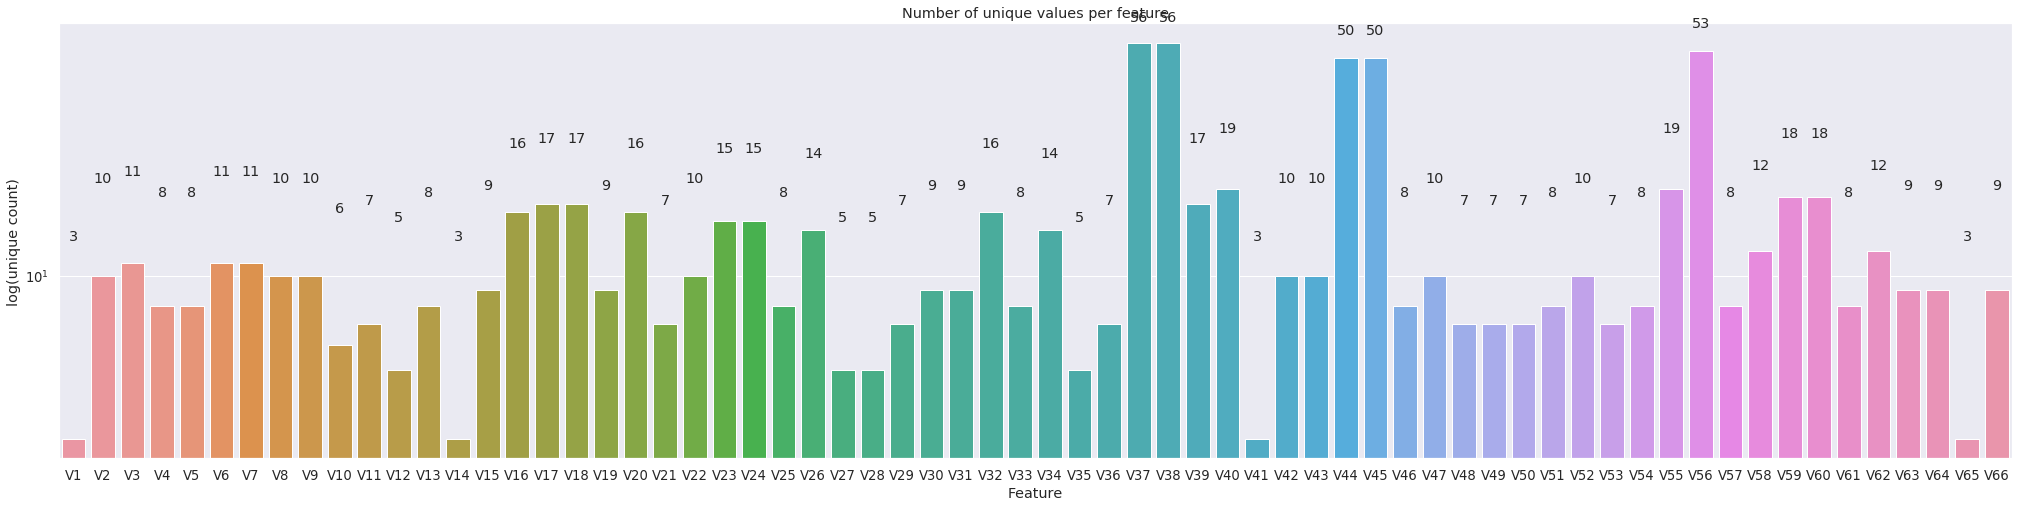

In [38]:
plt.figure(figsize=(35, 8))
v_features = list(train_transaction.columns[54:120])
uniques = [len(train_transaction[col].unique()) for col in v_features]
sns.set(font_scale=1.2)
ax = sns.barplot(v_features, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 

In [39]:
del v_features, uniques
gc.collect()

6860

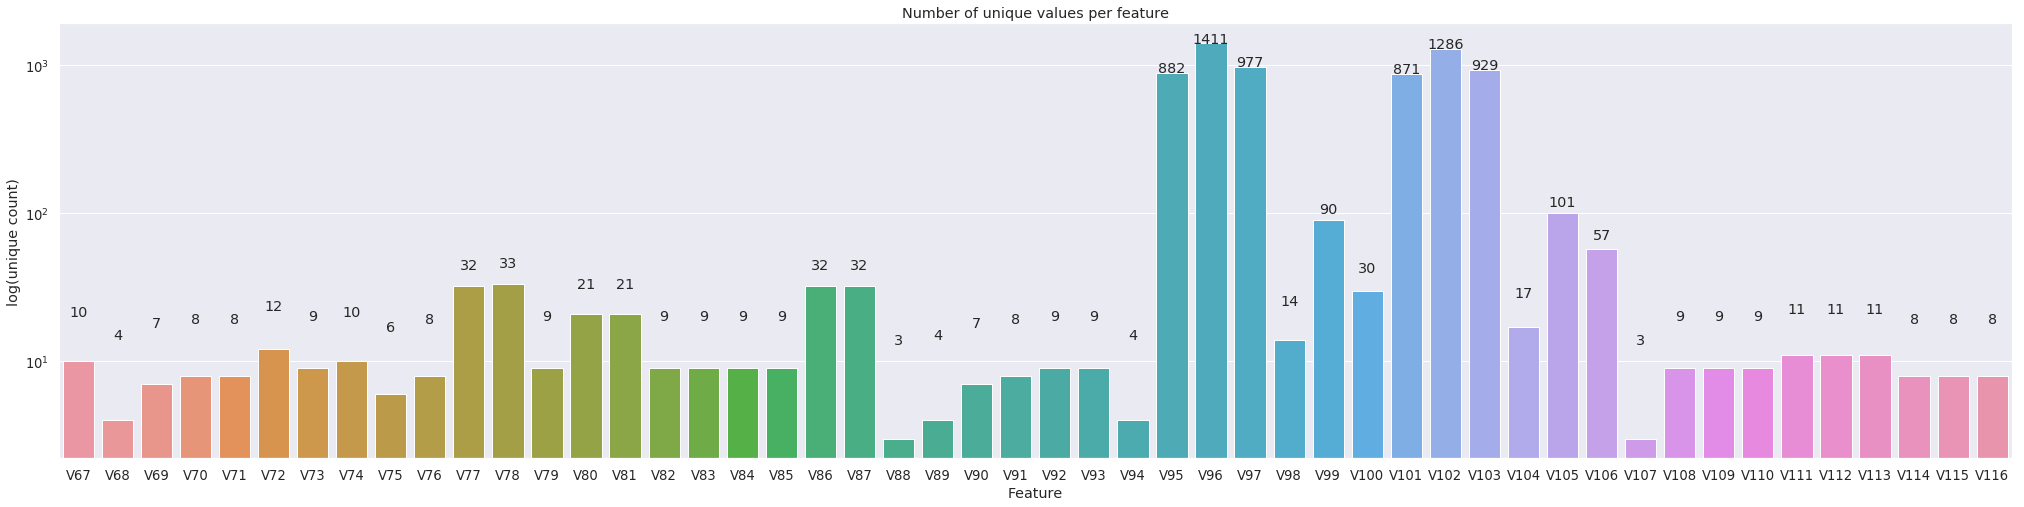

In [40]:
plt.figure(figsize=(35, 8))
v_features = list(train_transaction.columns[120:170])
uniques = [len(train_transaction[col].unique()) for col in v_features]
sns.set(font_scale=1.2)
ax = sns.barplot(v_features, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 

In [41]:
del v_features, uniques
gc.collect()

17716

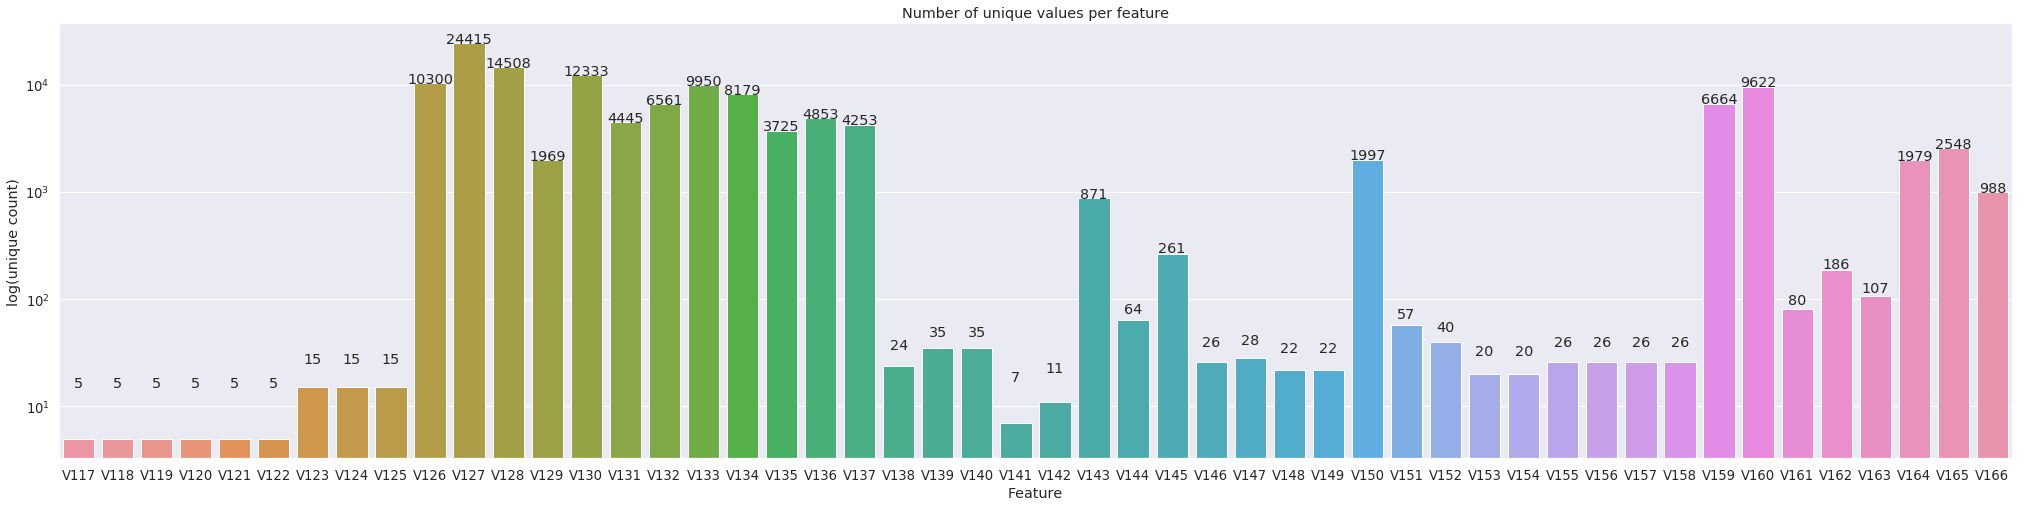

In [42]:
plt.figure(figsize=(35, 8))
v_features = list(train_transaction.columns[170:220])
uniques = [len(train_transaction[col].unique()) for col in v_features]
sns.set(font_scale=1.2)
ax = sns.barplot(v_features, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 

In [43]:
del v_features, uniques
gc.collect()

17129

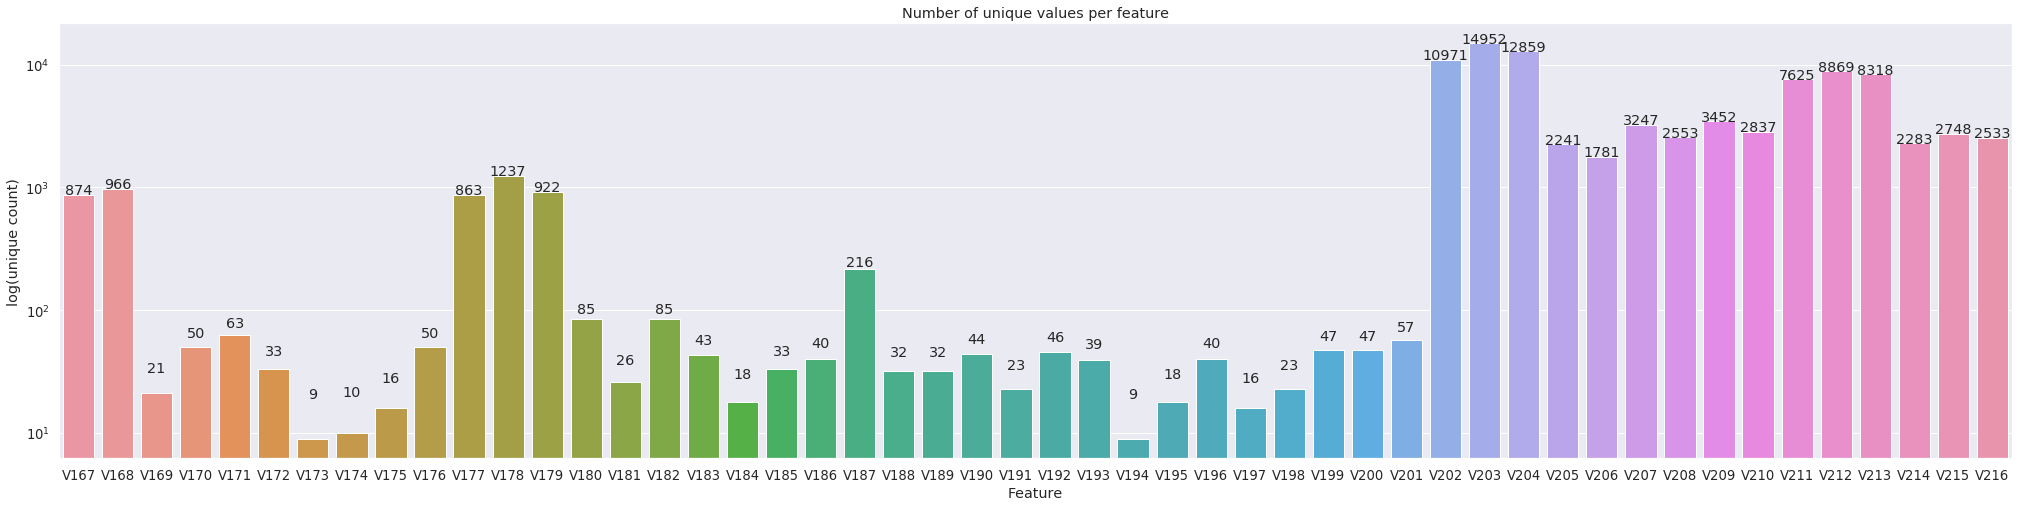

In [44]:
plt.figure(figsize=(35, 8))
v_features = list(train_transaction.columns[220:270])
uniques = [len(train_transaction[col].unique()) for col in v_features]
sns.set(font_scale=1.2)
ax = sns.barplot(v_features, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 

In [45]:
del v_features, uniques
gc.collect()

17594

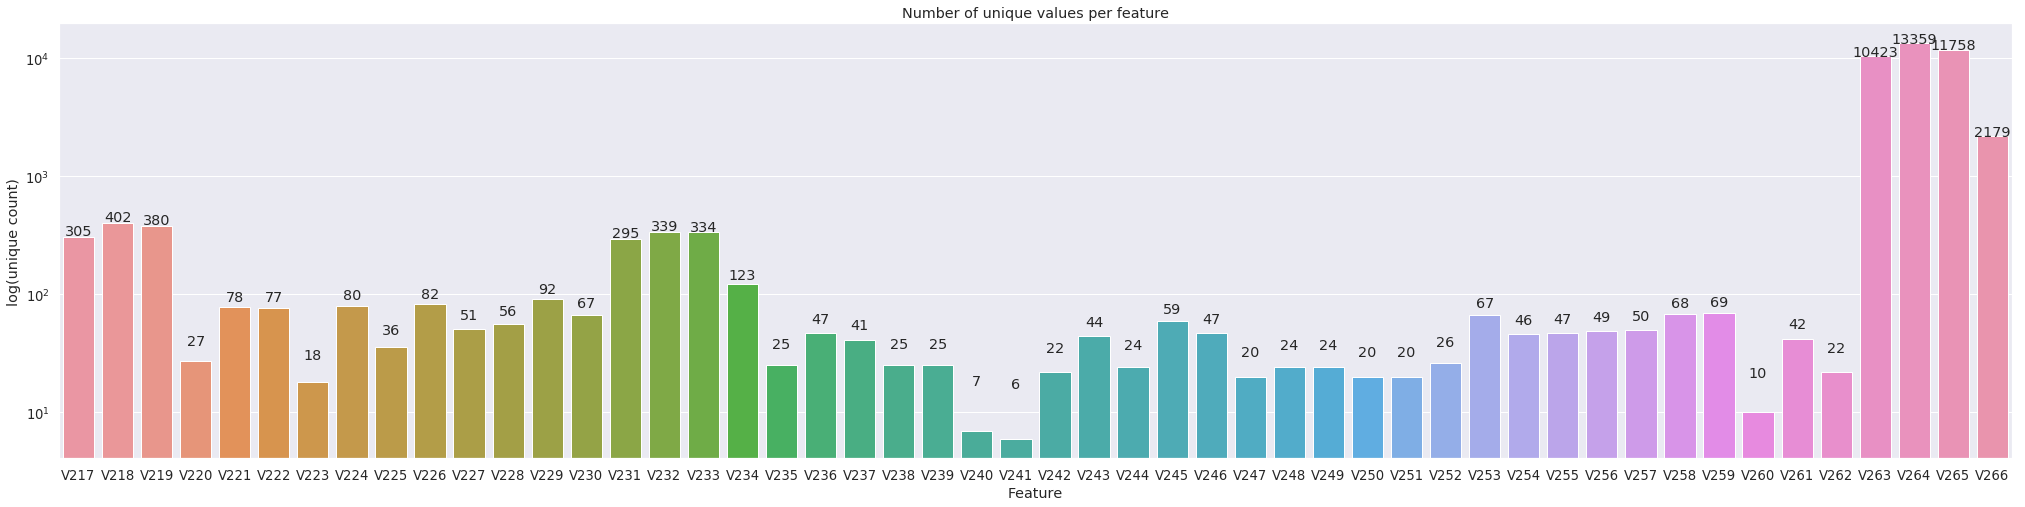

In [46]:
plt.figure(figsize=(35, 8))
v_features = list(train_transaction.columns[270:320])
uniques = [len(train_transaction[col].unique()) for col in v_features]
sns.set(font_scale=1.2)
ax = sns.barplot(v_features, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 

In [47]:
del v_features, uniques
gc.collect()

17602

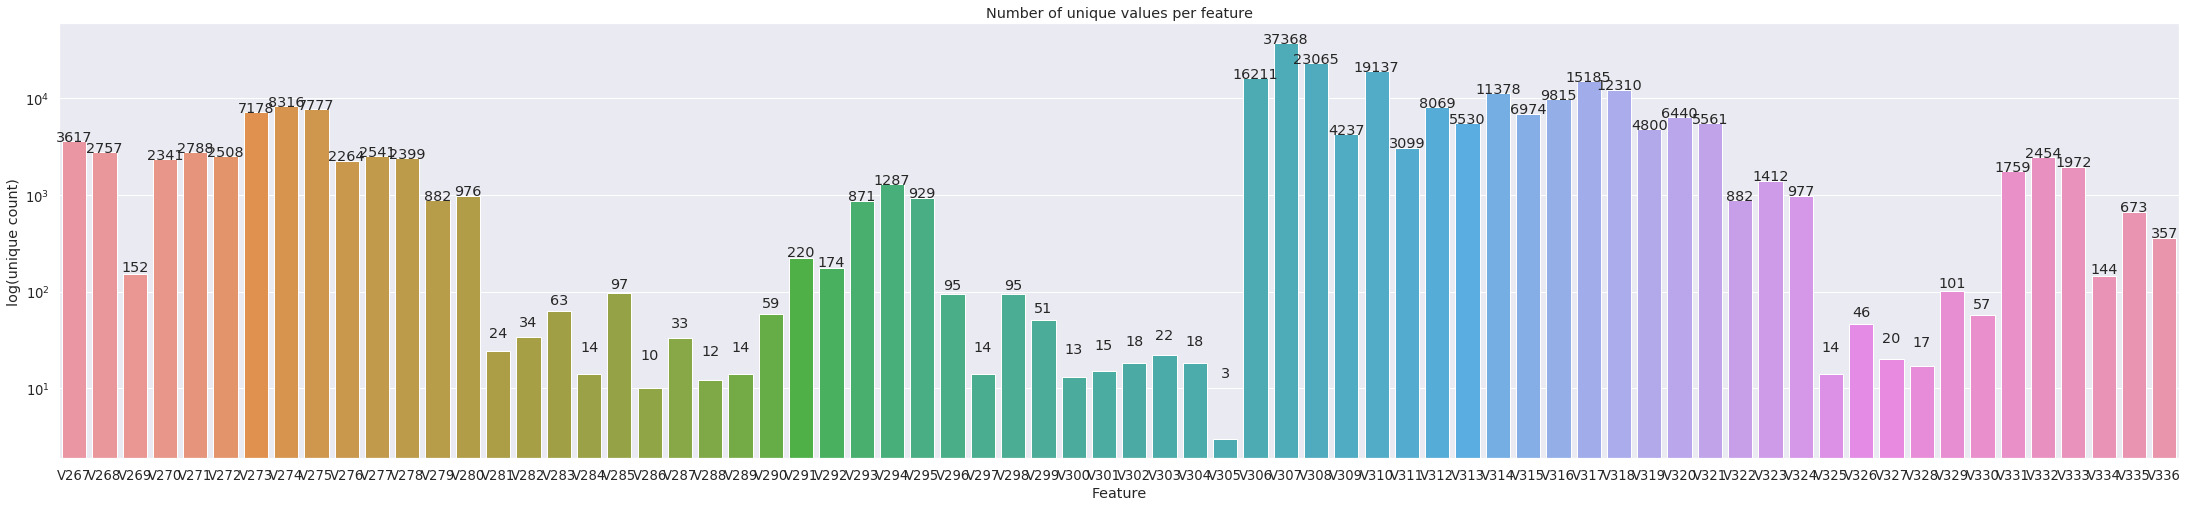

In [48]:
plt.figure(figsize=(38, 8))
v_features = list(train_transaction.columns[320:390])
uniques = [len(train_transaction[col].unique()) for col in v_features]
sns.set(font_scale=1.2)
ax = sns.barplot(v_features, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 

In [49]:
del v_features, uniques
gc.collect()

17073

**id_code**

In [48]:
train_identity.head()

,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


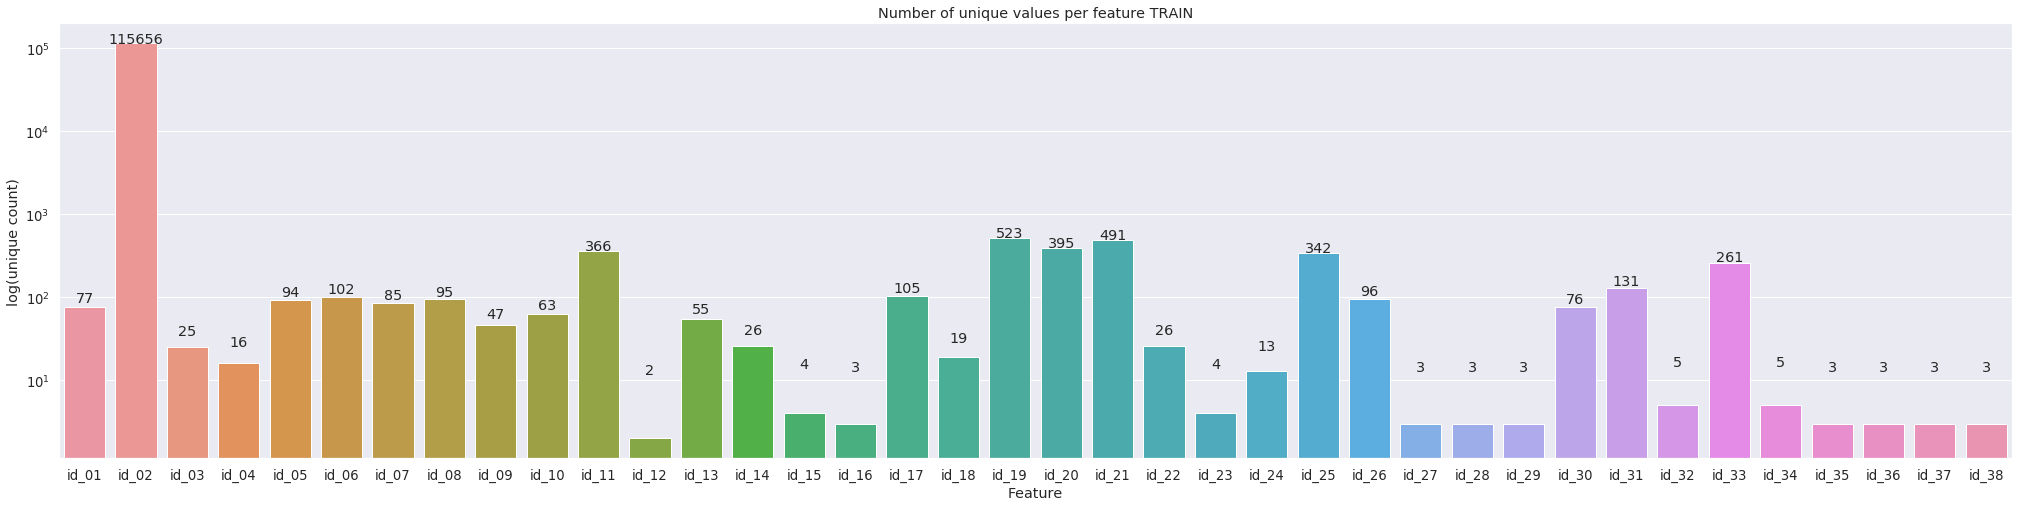

In [51]:
plt.figure(figsize=(35, 8))
features = list(train_identity.columns[0:38])
uniques = [len(train_identity[col].unique()) for col in features]
sns.set(font_scale=1.2)
ax = sns.barplot(features, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature TRAIN')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 

In [52]:
del features, uniques
gc.collect()

21161

**Categorical Features**

- ProductCD
- emaildomain
- card1 - card6
- addr1, addr2
- P_emaildomain
- R_emaildomain
- M1 - M9
- DeviceType
- DeviceInfo
- id_12 - id_38

In [53]:
train_transaction.head(6)

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2987005,0,86510,49.0,W,5937,555.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
train_identity.head(6)

,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS
2987017,-5.0,61141.0,3.0,0.0,3.0,0.0,NaN,NaN,3.0,0.0,...,chrome 62.0,24.0,1366x768,match_status:2,T,F,T,T,desktop,Windows


**ProductCD**

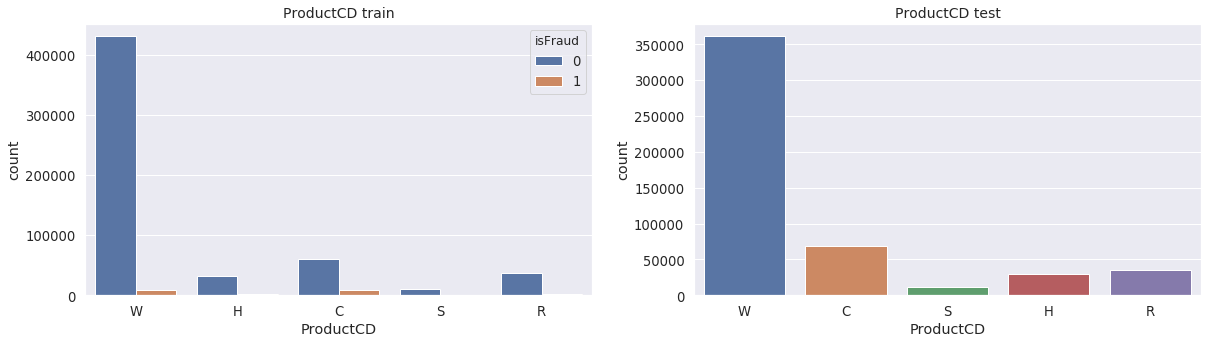

In [55]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))

sns.countplot(x="ProductCD", ax=ax[0], hue = "isFraud", data=train_transaction)
ax[0].set_title('ProductCD train', fontsize=14)
sns.countplot(x="ProductCD", ax=ax[1], data=test_transaction)
ax[1].set_title('ProductCD test', fontsize=14)
plt.show()

**Device Type & Device Info**

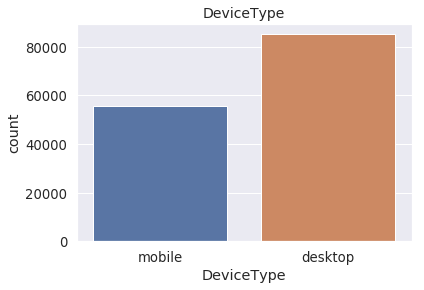

In [56]:
ax = sns.countplot(x="DeviceType", data=train_identity)
ax.set_title('DeviceType', fontsize=14)
plt.show()

**Device information**

In [57]:
print ("Unique Devices = ",train_identity['DeviceInfo'].nunique())
train_identity['DeviceInfo'].value_counts().head()

Unique Devices =  1786


Windows        47722
iOS Device     19782
MacOS          12573
Trident/7.0     7440
rv:11.0         1901
Name: DeviceInfo, dtype: int64

**Card**

In [58]:
cards = ['card1', 'card2', 'card3', 'card4', 'card5', 'card6']
for i in cards:
    print ("Unique ",i, " = ",train_transaction[i].nunique())

Unique  card1  =  13553
Unique  card2  =  500
Unique  card3  =  114
Unique  card4  =  4
Unique  card5  =  119
Unique  card6  =  4


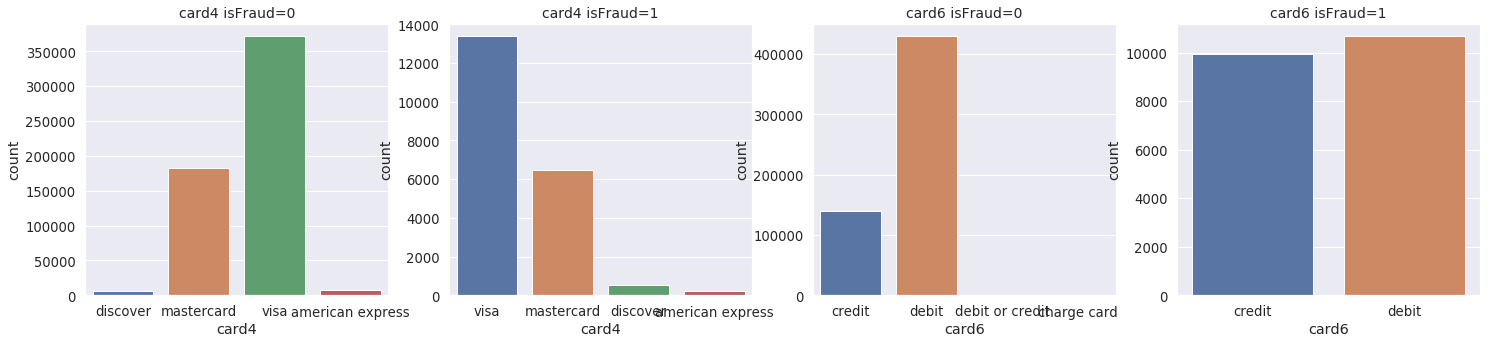

In [59]:
fig, ax = plt.subplots(1, 4, figsize=(25,5))

sns.countplot(x="card4", ax=ax[0], data=train_transaction.loc[train_transaction['isFraud'] == 0])
ax[0].set_title('card4 isFraud=0', fontsize=14)
sns.countplot(x="card4", ax=ax[1], data=train_transaction.loc[train_transaction['isFraud'] == 1])
ax[1].set_title('card4 isFraud=1', fontsize=14)
sns.countplot(x="card6", ax=ax[2], data=train_transaction.loc[train_transaction['isFraud'] == 0])
ax[2].set_title('card6 isFraud=0', fontsize=14)
sns.countplot(x="card6", ax=ax[3], data=train_transaction.loc[train_transaction['isFraud'] == 1])
ax[3].set_title('card6 isFraud=1', fontsize=14)
plt.show()

**Email Domain**

In [60]:
"emaildomain" in train_transaction.columns, "emaildomain" in train_identity.columns

(False, False)

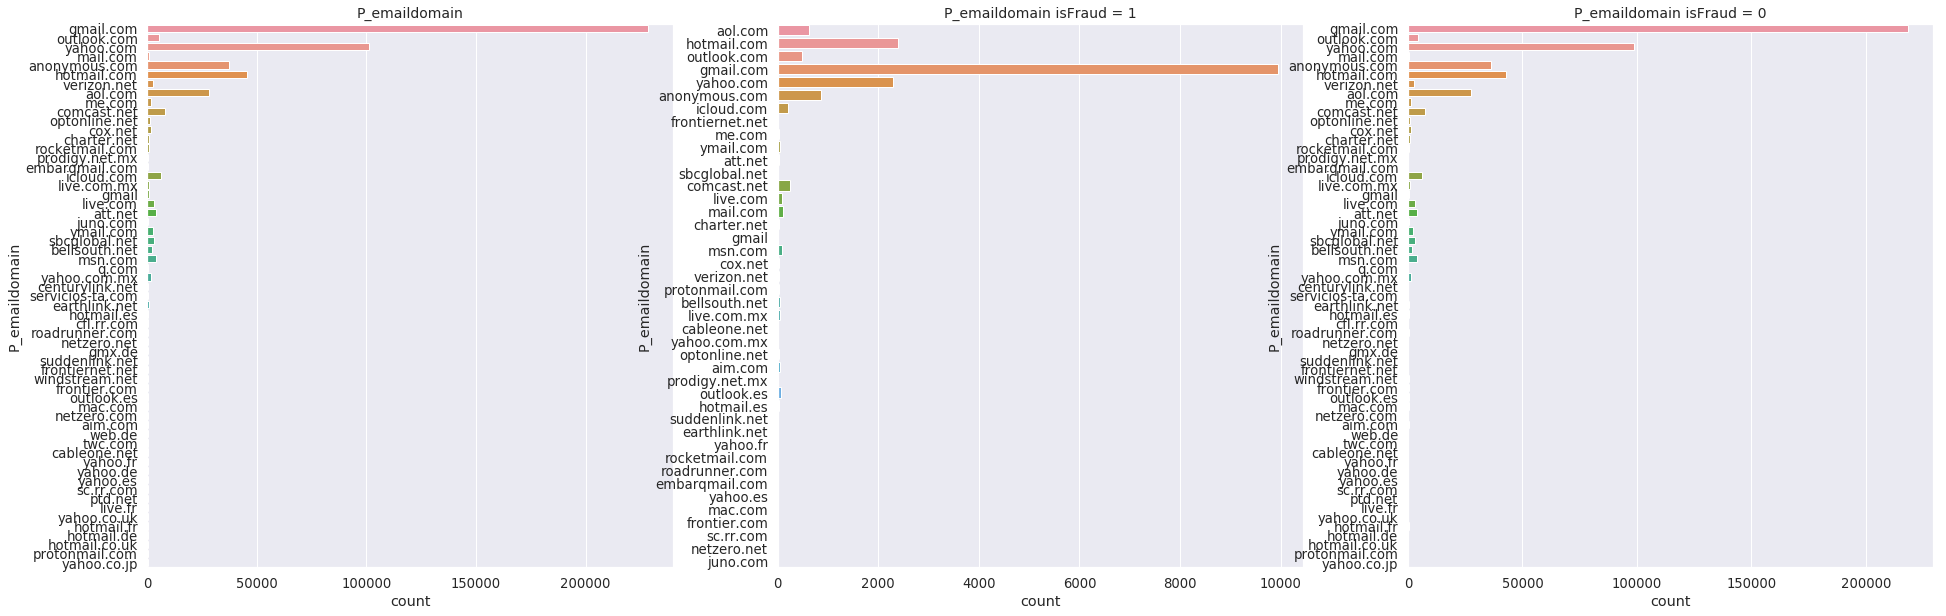

In [61]:
fig, ax = plt.subplots(1, 3, figsize=(32,10))

sns.countplot(y="P_emaildomain", ax=ax[0], data=train_transaction)
ax[0].set_title('P_emaildomain', fontsize=14)
sns.countplot(y="P_emaildomain", ax=ax[1], data=train_transaction.loc[train_transaction['isFraud'] == 1])
ax[1].set_title('P_emaildomain isFraud = 1', fontsize=14)
sns.countplot(y="P_emaildomain", ax=ax[2], data=train_transaction.loc[train_transaction['isFraud'] == 0])
ax[2].set_title('P_emaildomain isFraud = 0', fontsize=14)
plt.show()

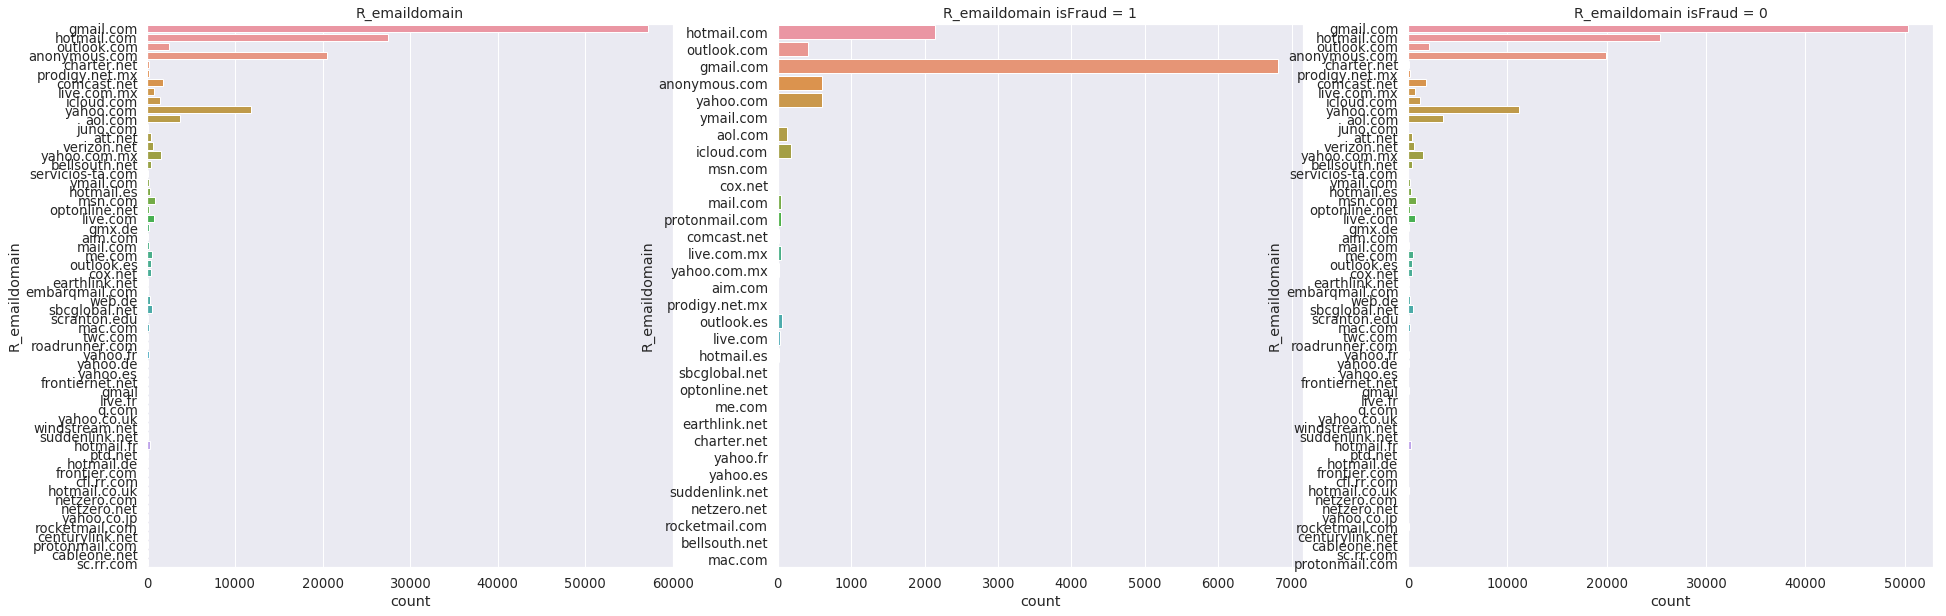

In [62]:
fig, ax = plt.subplots(1, 3, figsize=(32,10))

sns.countplot(y="R_emaildomain", ax=ax[0], data=train_transaction)
ax[0].set_title('R_emaildomain', fontsize=14)
sns.countplot(y="R_emaildomain", ax=ax[1], data=train_transaction.loc[train_transaction['isFraud'] == 1])
ax[1].set_title('R_emaildomain isFraud = 1', fontsize=14)
sns.countplot(y="R_emaildomain", ax=ax[2], data=train_transaction.loc[train_transaction['isFraud'] == 0])
ax[2].set_title('R_emaildomain isFraud = 0', fontsize=14)
plt.show()

**Il semble que les criminels préfèrent le gmail.**

In [63]:
del fig, ax
gc.collect()

20872

# <a style="color:#6699ff"> III. Preprocessing</a>

## Merge transaction & identity 

In [49]:
%%time
train_df = pd.merge(train_transaction, train_identity, on = "TransactionID", how = "left")
print("Tain: ",train_df.shape)
del train_transaction, train_identity
gc.collect()

Tain:  (590540, 433)
Wall time: 1min 1s


In [2]:
%%time
#test_df = pd.merge(test_transaction, test_identity, on = "TransactionID", how = "left")
#print("Test: ",test_df.shape)
#test_df["isFraud"] = 0
del test_transaction, test_identity
gc.collect()

Wall time: 0 ns


## Pipeline of preprocessing

In [9]:
emails = {
'gmail': 'google', 
'att.net': 'att', 
'twc.com': 'spectrum', 
'scranton.edu': 'other', 
'optonline.net': 'other', 
'hotmail.co.uk': 'microsoft',
'comcast.net': 'other', 
'yahoo.com.mx': 'yahoo', 
'yahoo.fr': 'yahoo',
'yahoo.es': 'yahoo', 
'charter.net': 'spectrum', 
'live.com': 'microsoft', 
'aim.com': 'aol', 
'hotmail.de': 'microsoft', 
'centurylink.net': 'centurylink',
'gmail.com': 'google', 
'me.com': 'apple', 
'earthlink.net': 'other', 
'gmx.de': 'other',
'web.de': 'other', 
'cfl.rr.com': 'other', 
'hotmail.com': 'microsoft', 
'protonmail.com': 'other', 
'hotmail.fr': 'microsoft', 
'windstream.net': 'other', 
'outlook.es': 'microsoft', 
'yahoo.co.jp': 'yahoo', 
'yahoo.de': 'yahoo',
'servicios-ta.com': 'other', 
'netzero.net': 'other', 
'suddenlink.net': 'other',
'roadrunner.com': 'other', 
'sc.rr.com': 'other', 
'live.fr': 'microsoft',
'verizon.net': 'yahoo', 
'msn.com': 'microsoft', 
'q.com': 'centurylink', 
'prodigy.net.mx': 'att', 
'frontier.com': 'yahoo', 
'anonymous.com': 'other', 
'rocketmail.com': 'yahoo',
'sbcglobal.net': 'att',
'frontiernet.net': 'yahoo', 
'ymail.com': 'yahoo',
'outlook.com': 'microsoft',
'mail.com': 'other', 
'bellsouth.net': 'other',
'embarqmail.com': 'centurylink',
'cableone.net': 'other', 
'hotmail.es': 'microsoft', 
'mac.com': 'apple',
'yahoo.co.uk': 'yahoo',
'netzero.com': 'other', 
'yahoo.com': 'yahoo', 
'live.com.mx': 'microsoft',
'ptd.net': 'other',
'cox.net': 'other',
'aol.com': 'aol',
'juno.com': 'other',
'icloud.com': 'apple'
}

# number types for filtering the columns
int_types = ["int8", "int16", "int32", "int64", "float"]

In [19]:
# Let's check how many missing values has each column.

def check_nan(df, limit):
    '''
    Check how many values are missing in each column.
    If the number of missing values are higher than limit, we drop the column.
    '''
    
    total_rows = df.shape[0]
    total_cols = df.shape[1]
    
    total_dropped = 0
    col_to_drop = []
    
    for col in df.columns:

        null_sum = df[col].isnull().sum()
        perc_over_total = round((null_sum/total_rows), 2)
        
        if perc_over_total > limit:
            
            print("The col {} contains {} null values.\nThis represents {} of total rows."\
                  .format(col, null_sum, perc_over_total))
            
            print("Dropping column {} from the df.\n".format(col))
            
            col_to_drop.append(col)
            total_dropped += 1            
    
    df.drop(col_to_drop, axis = 1, inplace = True)
    print("We have dropped a total of {} columns.\nIt's {} of the total"\
          .format(total_dropped, round((total_dropped/total_cols), 2)))
    
    return df

In [20]:
def binarizer(df_train, df_test):
    '''
    Work with cat features and binarize the values.
    Works with 2 dataframes at a time and returns a tupple of both.
    '''
    cat_cols = df_train.select_dtypes(exclude=int_types).columns

    for col in cat_cols:
        
        # creating a list of unique features to binarize so we dont get and value error
        unique_train = list(df_train[col].unique())
        unique_test = list(df_test[col].unique())
        unique_values = list(set(unique_train + unique_test))
        
        enc = LabelEncoder()
        enc.fit(unique_values)
        
        df_train[col] = enc.transform((df_train[col].values).reshape(-1 ,1))
        df_test[col] = enc.transform((df_test[col].values).reshape(-1 ,1))
    
    return (df_train, df_test)

In [21]:
def cathegorical_imputer(df_train, df_test, strategy, fill_value):
    '''
    Replace all cathegorical features with a constant or the most frequent strategy.
    '''
    cat_cols = df_train.select_dtypes(exclude=int_types).columns
    
    for col in cat_cols:
        print("Working with column {}".format(col))
        
        # select the correct inputer
        if strategy == "constant":
            # input a fill_value of -999 to all nulls
            inputer = SimpleImputer(strategy=strategy, fill_value=fill_value)
        elif strategy == "most_frequent":
            inputer = SimpleImputer(strategy=strategy)
        
        # replace the nulls in train and test
        df_train[col] = inputer.fit_transform(X = (df_train[col].values).reshape(-1, 1))
        df_test[col] = inputer.transform(X = (df_test[col].values).reshape(-1, 1))
        
    return (df_train, df_test)

In [22]:
def numerical_inputer(df_train, df_test, strategy, fill_value):
    '''
    Replace NaN in the numerical features.
    Works with 2 dataframes at a time (train & test).
    Return a tupple of both.
    '''
    
    # assert valid strategy
    message = "Please select a valid strategy (mean, median, constant (and give a fill_value) or most_frequent)"
    assert strategy in ["constant", "most_frequent", "mean", "median"], message
    
    # int_types defined earlier in the kernel
    num_cols = df_train.select_dtypes(include = int_types).columns
    
    for col in num_cols:

        print("Working with column {}".format(col))

        # select the correct inputer
        if strategy == "constant":
            inputer = SimpleImputer(strategy=strategy, fill_value=fill_value)
        elif strategy == "most_frequent":
            inputer = SimpleImputer(strategy=strategy)
        elif strategy == "mean":
            inputer = SimpleImputer(strategy=strategy)
        elif strategy == "median":
            inputer = SimpleImputer(strategy=strategy)

        # replace the nulls in train and test
        try:
            df_train[col] = inputer.fit_transform(X = (df_train[col].values).reshape(-1, 1))
            df_test[col] = inputer.transform(X = (df_test[col].values).reshape(-1, 1))
        except:
            print("Col {} gave and error.".format(col))
            
    return (df_train, df_test)

In [25]:
def pipeline(df_train, df_test):
    '''
    We define a personal pipeline to process the data and fill with processing functions.
    NOTE: modifies the df in place.
    '''
    print("Shape of train is {}".format(df_train.shape))
    print("Shape of test is {}".format(df_test.shape))
    # We have set the limit of 70%. If a column contains more that 70% of it's values as NaN/Missing values we will drop the column
    # Since it's very unlikely that it will help our future model.
    print("Checking for nan values\n")
    df_train = check_nan(df_train, limit=0.7)
    
    # Select the columns from df_train with less nulls and asign to test.
    df_test = df_test[list(df_train.columns)]
          
    print("Shape of train is {}".format(df_train.shape))
    print("Shape of test is {}".format(df_test.shape))
          
    # mapping emails
    print("Mapping emails \n")
    df_train["EMAILP"] = df_train["P_emaildomain"].map(emails)
    df_test["EMAILP"] = df_test["P_emaildomain"].map(emails)

    print("Shape of train is {}".format(df_train.shape))
    print("Shape of test is {}".format(df_test.shape))
          
    # replace nulls from the train and test df with a value of "Other"
    print("Working with cathegorical values\n")
    df_train, df_test = cathegorical_imputer(df_train, df_test, strategy = "constant", fill_value = "Other")
    
    print("Shape of train is {}".format(df_train.shape))
    print("Shape of test is {}".format(df_test.shape))
          
    # now we will make a one hot encoder of these colums
    print("Binarazing values\n")
    df_train, df_test = binarizer(df_train, df_test)
    
    print("Shape of train is {}".format(df_train.shape))
    print("Shape of test is {}".format(df_test.shape))
          
    # working with null values in numeric columns
    print("Working with numerical columns. NAN values\n")
    df_train, df_test = numerical_inputer(df_train, df_test, strategy = "constant", fill_value=-999)
        
    print("Shape of train is {}".format(df_train.shape))
    print("Shape of test is {}".format(df_test.shape))
          
    return (df_train, df_test)

In [1]:
# before preprocesing
#print("Train before preprocesing: ",train_df.shape)
#print("Test before preprocesing: ",test_df.shape)

#train_df, test_df = pipeline(train_df, test_df)

# after preprocesing
#print("Train after preprocesing: ",train_df.shape)
print("Test after preprocesing: ",test_df.shape)

In [18]:
# check for null values
columns = train_df.columns
for col in  columns:
    total_nulls = train_df[col].isnull().sum()
    if total_nulls > 0:
        print(col, total_nulls)
        
columns = test_df.select_dtypes(exclude=int_types).columns
train_df[columns]

columns = test_df.select_dtypes(include=int_types).columns
train_df[columns]

card2 8933
card3 1565
card5 4259
addr1 65706
addr2 65706
dist1 352271
D1 1269
D2 280797
D3 262878
D4 168922
D5 309841
D10 76022
D11 279287
D15 89113
V1 279287
V2 279287
V3 279287
V4 279287
V5 279287
V6 279287
V7 279287
V8 279287
V9 279287
V10 279287
V11 279287
V12 76073
V13 76073
V14 76073
V15 76073
V16 76073
V17 76073
V18 76073
V19 76073
V20 76073
V21 76073
V22 76073
V23 76073
V24 76073
V25 76073
V26 76073
V27 76073
V28 76073
V29 76073
V30 76073
V31 76073
V32 76073
V33 76073
V34 76073
V35 168969
V36 168969
V37 168969
V38 168969
V39 168969
V40 168969
V41 168969
V42 168969
V43 168969
V44 168969
V45 168969
V46 168969
V47 168969
V48 168969
V49 168969
V50 168969
V51 168969
V52 168969
V53 77096
V54 77096
V55 77096
V56 77096
V57 77096
V58 77096
V59 77096
V60 77096
V61 77096
V62 77096
V63 77096
V64 77096
V65 77096
V66 77096
V67 77096
V68 77096
V69 77096
V70 77096
V71 77096
V72 77096
V73 77096
V74 77096
V75 89164
V76 89164
V77 89164
V78 89164
V79 89164
V80 89164
V81 89164
V82 89164
V83 89164
V

KeyError: "Index(['R_emaildomain', 'id-12', 'id-15', 'id-16', 'id-23', 'id-27', 'id-28',\n       'id-29', 'id-30', 'id-31', 'id-33', 'id-34', 'id-35', 'id-36', 'id-37',\n       'id-38', 'DeviceType', 'DeviceInfo'],\n      dtype='object') not in index"

**Reduce Memory Usage**

In [19]:
%%time
# From kernel https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

Wall time: 995 µs


In [20]:
%%time
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 991.20 MB
Memory usage after optimization is: 272.02 MB
Decreased by 72.6%
Memory usage of dataframe is 850.46 MB
Memory usage after optimization is: 237.26 MB
Decreased by 72.1%
Wall time: 2min 12s


# <a style="color:#6699ff"> IV. Machine Learning Models</a>

In [21]:
cols_to_drop = ["TransactionID", "isFraud", "TransactionDT"]
useful_cols = list(train_df.columns)

for col in cols_to_drop:
    while True:
        try:
            useful_cols.remove(col)
        except:
            break
            
Y = train_df["isFraud"]
X = train_df[useful_cols]

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

**Reduce Memory Usage**

In [23]:
%%time
X_train = reduce_mem_usage(X_train)
X_test = reduce_mem_usage(X_test)

Memory usage of dataframe is 180.36 MB
Memory usage after optimization is: 175.84 MB
Decreased by 2.5%
Memory usage of dataframe is 88.84 MB
Memory usage after optimization is: 88.84 MB
Decreased by 0.0%
Wall time: 18.5 s


### KNN

In [36]:
from sklearn import neighbors

knn = neighbors.KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

In [37]:
pred_train = knn.predict_proba(X_train)

In [41]:
print("score auc train :",roc_auc_score(y_train, pred_train[:, 1]))

score auc train : 0.9890928498077949


#### Prediction_test_Knn

In [59]:
%%time
pred_test=knn.predict_proba(test_df[useful_cols])

Wall time: 1h 54min 23s


In [62]:
pred_test[:,1]

array([0., 0., 0., ..., 0., 0., 0.])

In [73]:
submission_knn = pd.read_csv('sample_submission.csv', index_col='TransactionID')
submission_knn['isFraud'] =pred_test[:,1]
submission_knn.head()

,isFraud
TransactionID,
3663549,0.0
3663550,0.0
3663551,0.0
3663552,0.0
3663553,0.0


In [68]:
submission_knn.to_csv('submission1.csv',index='TransactionID')

In [69]:
sub=pd.read_csv('submission1.csv')

In [72]:
sub.head()

,TransactionID,isFraud
0,3663549,0.0
1,3663550,0.0
2,3663551,0.0
3,3663552,0.0
4,3663553,0.0


### Regression Tree

In [74]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [75]:
%%time
pred_train_Tree = clf.predict_proba(X_train)

Wall time: 1.23 s


In [77]:
pred_train_Tree 

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]])

In [78]:
print("score auc train :",roc_auc_score(y_train, pred_train_Tree[:, 1]))  

score auc train : 0.999999830792383


#### Prediction_Test_Tree

In [79]:
%%time
pred_test_Tree=clf.predict_proba(test_df[useful_cols])

Wall time: 2.91 s


In [83]:
submission_Tree= pd.read_csv('sample_submission.csv', index_col='TransactionID')
submission_Tree['isFraud']=pred_test_Tree[:,1]
submission_Tree['isFraud'].unique()

array([0.        , 1.        , 0.16666667, 0.5       , 0.25      ,
       0.33333333])

In [84]:
submission_Tree.to_csv('Tree_submission.csv',index='TransactionID')

In [86]:
sub1=pd.read_csv('Tree_submission.csv')
sub1

,TransactionID,isFraud
0,3663549,0.0
1,3663550,0.0
2,3663551,0.0
3,3663552,0.0
4,3663553,0.0
5,3663554,0.0
6,3663555,0.0
7,3663556,0.0
8,3663557,0.0
9,3663558,0.0


### Logistic Regression

In [88]:
from sklearn.linear_model import LogisticRegression

In [89]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [91]:
%%time
y_pred = logreg.predict_proba(X_test)

Wall time: 798 ms


In [92]:
y_pred

array([[0.9790475 , 0.0209525 ],
       [0.99473826, 0.00526174],
       [0.91691661, 0.08308339],
       ...,
       [0.9948089 , 0.0051911 ],
       [0.98927384, 0.01072616],
       [0.99881829, 0.00118171]])

In [93]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.96


#### predict_test_logR

In [94]:
y_pred_lr=logreg.predict_proba(test_df[useful_cols])

In [96]:
submission_lr= pd.read_csv('sample_submission.csv', index_col='TransactionID')
submission_lr['isFraud']=y_pred_lr[:,1]
submission_lr.head()

,isFraud
TransactionID,
3663549,0.005479
3663550,0.003140
3663551,0.064969
3663552,0.021203
3663553,0.037116


In [97]:
submission_lr.to_csv('lr_submission.csv',index='TransactionID')

### Randomn Forest

In [24]:
import sklearn.ensemble as ensem

In [25]:
rft =  ensem.RandomForestClassifier(criterion='entropy',max_depth=30,
                                   n_estimators=500,verbose=0)

In [26]:
rft.fit(X_train,y_train)
predVal = rft.predict(X_test)
actVal = y_test.values

In [28]:
import sklearn.metrics as metric

In [30]:
print(metric.confusion_matrix(actVal, predVal))
print(metric.accuracy_score(actVal, predVal))

[[187703    230]
 [  3891   3055]]
0.9788535450202434


In [31]:
y_pred_rf=rft.predict_proba(test_df[useful_cols])